In this nootebook the matched census and election data is explored with linear methods for understanding the most important factors affecting election results.

In [28]:
#basic libraries
import pickle

import numpy as np

import pandas as pd
#for categorial ordering 
from pandas.api.types import CategoricalDtype

import scipy as sp
from scipy.fft import fft, fftfreq

from datetime import date, time, datetime
from dateutil.parser import parse

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

import statsmodels.formula.api as sm
import statsmodels.tsa.stattools as smtime
#We mainly use xgboost
from xgboost import XGBClassifier
import xgboost as xgb

#some skitlearn tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

#trials
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import sklearn.metrics as met
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

We are loading the combined data frame. 

In [29]:
sel2=pd.read_csv('census_election_v1.csv')
print(f" shape of data frame {sel2.shape}")

print(f" total number of communities {sel2.eligible_voters.count()}")
print(f" total number of eligible voters {sel2.eligible_voters.sum()}")

 shape of data frame (5098, 338)
 total number of communities 5098
 total number of eligible voters 54177266


Now we identifying the columns which contain the census properties.

In [30]:
print(sel2.columns[0:9])
print(sel2.columns[223:226])
#tranfer census property to list column_names
#is copy paste method for getting type
column_names=['AGS_12']
for i in range(1, 223):
    column_names.append(sel2.columns[i+1])

Index(['Unnamed: 0', 'AGS_12', 'RS_Land', 'RS_RB_NUTS2', 'RS_Kreis', 'RS_VB',
       'RS_Gemeinde', 'Name', 'Reg_Hier'],
      dtype='object')
Index(['PhD_and_MD', 'Reg_hier', 'land_name'], dtype='object')


Now  get which fractions of communities and population have information. 

In [31]:
print(column_names[8])
xs=8
print(f"census properties start at {xs}")
#split germany for get records
selw=sel2[(sel2['unification']=='West')].copy()
sele=sel2[(sel2['unification']=='East')].copy() 
stat=np.empty((9,len(column_names),3))
stat[1,:,0]=sel2.eligible_voters.sum()
stat[4,:,0]=sel2.eligible_voters.count()
stat[1,:,1]=selw.eligible_voters.sum()
stat[4,:,1]=selw.eligible_voters.count()
stat[1,:,2]=sele.eligible_voters.sum()
stat[4,:,2]=sele.eligible_voters.count()           
for i in range (xs, 223):
    stat[0,i,:]=i
    stat[2,i,0]=sel2.eligible_voters[(sel2[column_names[i]]>-0.5)].sum()
    stat[3,i,0]=sel2.eligible_voters[(sel2[column_names[i]]>-0.5)].sum()  
    stat[5,i,0]=sel2.eligible_voters[(sel2[column_names[i]]>-0.5)].count()
    stat[6,i,0]=sel2.eligible_voters[(sel2[column_names[i]]>-0.5)].count()
    stat[7,i,0]=sel2[column_names[i]][(sel2[column_names[i]]>-0.5)].sum() 
    stat[8,i,0]=sel2[column_names[i]][(sel2[column_names[i]]>-0.5)].sum() 
    stat[2,i,1]=selw.eligible_voters[(selw[column_names[i]]>-0.5)].sum()
    stat[3,i,1]=selw.eligible_voters[(selw[column_names[i]]>-0.5)].sum()  
    stat[5,i,1]=selw.eligible_voters[(selw[column_names[i]]>-0.5)].count()
    stat[6,i,1]=selw.eligible_voters[(selw[column_names[i]]>-0.5)].count()
    stat[7,i,1]=selw[column_names[i]][(selw[column_names[i]]>-0.5)].sum() 
    stat[8,i,1]=selw[column_names[i]][(selw[column_names[i]]>-0.5)].sum() 
    stat[2,i,2]=sele.eligible_voters[(sele[column_names[i]]>-0.5)].sum()
    stat[3,i,2]=sele.eligible_voters[(sele[column_names[i]]>-0.5)].sum()  
    stat[5,i,2]=sele.eligible_voters[(sele[column_names[i]]>-0.5)].count()
    stat[6,i,2]=sele.eligible_voters[(sele[column_names[i]]>-0.5)].count()
    stat[7,i,2]=sele[column_names[i]][(sele[column_names[i]]>-0.5)].sum() 
    stat[8,i,2]=sele[column_names[i]][(sele[column_names[i]]>-0.5)].sum()            
print(f"mean number of communities with information is {round(np.mean(stat[6,xs:len(column_names),0]))}")    
print(f"smallest number of communities with information is {min(stat[6,xs:len(column_names),0])} for {column_names[np.argmin(stat[6,xs:len(column_names),0])+8]}")

population
census properties start at 8
mean number of communities with information is 3227
smallest number of communities with information is 1.0 for migration_regions_nan


The number of communities with information varies, we now plot all.  

Text(0, 0.5, '% of eligible voters w information')

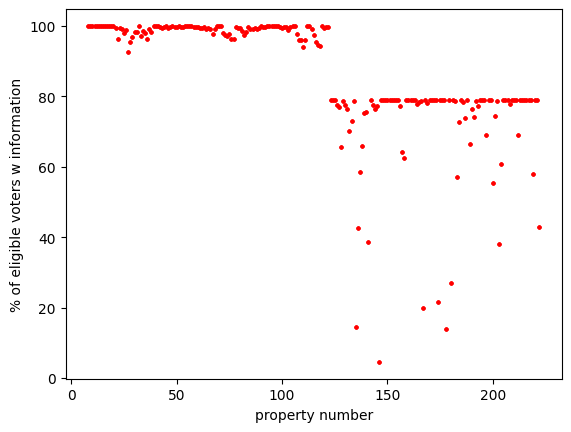

In [32]:
plt.plot(stat[0,xs:len(column_names)],100*stat[2,xs:len(column_names),0]/stat[1,xs:len(column_names),0],'o',ms=2,color='red')  
plt.xlabel("property number")
plt.ylabel("% of eligible voters w information")

Before about 120 the information is partly available for all. After it not. That is more visisble for communities, see below. 

[[4996. 4386.  610.]
 [4971. 4279.  692.]
 [4993. 4300.  693.]
 [1472. 1252.  220.]
 [1472. 1252.  220.]
 [1468. 1252.  216.]
 [1410. 1252.  158.]
 [1376. 1243.  133.]
 [ 993.  975.   18.]
 [1457. 1252.  205.]]
including 122 there is most information there


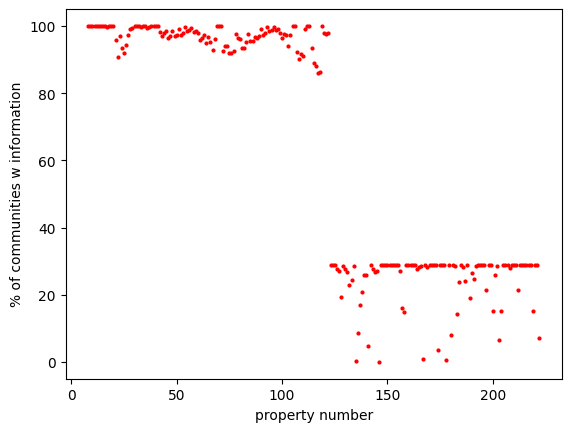

In [33]:
plt.plot(stat[0,xs:len(column_names),0],100*stat[5,xs:len(column_names),0]/stat[4,xs:len(column_names),0],'o',ms=2,color='red') 
plt.xlabel("property number")
plt.ylabel("% of communities w information")
print(stat[5,120:130])
print("including 122 there is most information there")
#setting parmeterw from which on less information is there 
xb=123

Now we check which properties have especially little information, the ones where less than 1000 communities have data.

In [34]:
for i in range (xb,len(column_names)):
    if(stat[6,i,0]<1000):
        print(column_names[i])
        print(f"available for {round(stat[3,i,1]/10**6,3)} millions/{round(100*stat[3,i,1]/max(stat[3,xb:len(column_names),1]),1)} % eligibile voters and {int(stat[6,i,1])} communities in the West")
        print(f"available for {round(stat[3,i,2]/10**6,3)} millions/{round(100*stat[3,i,2]/max(stat[3,xb:len(column_names),1]),2)} % eligibile voters and {int(stat[6,i,2])} communities in the East")
        print(" ")

migration_background_foreign_german_born
available for 31.124 millions/90.3 % eligibile voters and 975 communities in the West
available for 4.491 millions/13.03 % eligibile voters and 18 communities in the East
 
migration_56-59
available for 5.414 millions/15.7 % eligibile voters and 11 communities in the West
available for 2.469 millions/7.16 % eligibile voters and 1 communities in the East
 
migration_60-69
available for 20.618 millions/59.8 % eligibile voters and 444 communities in the West
available for 2.469 millions/7.16 % eligibile voters and 1 communities in the East
 
migration_70-79
available for 29.192 millions/84.7 % eligibile voters and 855 communities in the West
available for 2.482 millions/7.2 % eligibile voters and 2 communities in the East
 
migration_year_nan
available for 17.068 millions/49.5 % eligibile voters and 241 communities in the West
available for 3.805 millions/11.04 % eligibile voters and 7 communities in the East
 
migration_regions_nan
available for 0

Some of those categories are of nan type or subcategories and rare like soldier and thus omitting them should not be a problem. Some of it is also influences by East, West difeferent, there was less immigration in the EAST and idffernces in the school differences between states have also an impact. 

However, there are a few which are more different and which seem important. An example is shown below. 
We look on some of rare properties which are relative different from others, to see whether there is a signal visisble. 

Text(0, 0.5, '% libertarian vote share')

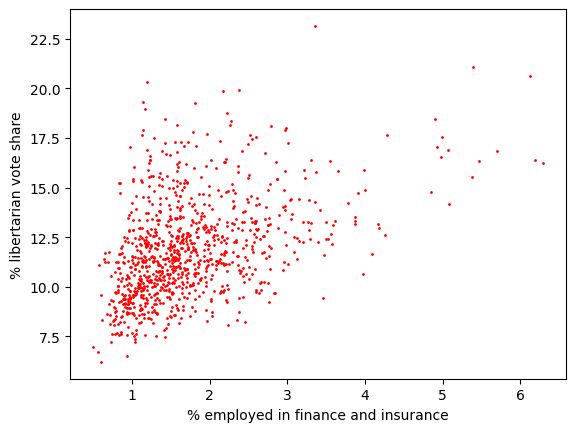

In [35]:

plt.plot(100*sel2['finance_insurance']/sel2['population'],100*sel2['libertarians_party_votes']/sel2['valid_party_votes'],'o',ms=1,color='red') 
#plt.legend(loc="best")
plt.xlabel("% employed in finance and insurance")
plt.ylabel("% libertarian vote share")
#plt.xlim(0,7)

The information is mostly complete until property 123. Therefore, we are now looking on all properties in columns 8 to 123. We will exclude the ones which fully include non voters like non citizen and citizens below 18, duplicates and properties which just summarize for how many of one category there is any information. There are also two age grouping in total, we use the one which has one border below 17 to exclude non voters. 

In [37]:
#for all properties we also get which fraction of population is included
pop=np.zeros((3,57,3))
pop[2,:,0]=np.arange(0,57,1)
listg1=column_names[10:12]
pop[0,0:2,:]=stat[8,10:12,:]
for i in range (15, 39):
    listg1.append(column_names[i])
    pop[0,2+(i-15),:]=stat[8,i,:]
for i in range (84, 105):
    listg1.append(column_names[i])
    pop[0,26+(i-84),:]=stat[8,i,:]    
listg1.append(column_names[106])
pop[0,47,:]=stat[8,106,:] 
for i in range (113, 119):
    listg1.append(column_names[i])
    pop[0,48+(i-113),:]=stat[8,i] 
for i in range (120, 123):
    listg1.append(column_names[i])
    pop[0,54+(i-120),:]=stat[8,i,:]     
print(f"included properties are {listg1}")
print(f"the number of properties is {len(listg1)}")
#get fraction of total population
pop[1]=pop[0]/sel2.population.sum()
print(f"smallest % of population is {round(min(pop[1,:,0])*100,5)} %")
print(f"largest population fraction {round(max(pop[1,:,0])*100,5)} %")

included properties are ['male', 'female', 'single_total', 'single_male', 'single_female', 'married_total', 'married_male', 'married_female', 'widowed_total', 'widowed_male', 'widowed_female', 'divorced_total', 'divorced_male', 'divorced_female', 'civil_union_total', 'civil_union_male', 'civil_union_female', 'civil_union_widowed_total', 'civil_union_widowed_male', 'civil_union_widowed_female', 'civil_union_divorced_total', 'civil_union_divorced_male', 'civil_union_divorved_female', 'not_specified_total', 'not_specified_male', 'not_specified_female', 'total_18_24', 'male_18_24', 'female_18_24', 'total_25_29', 'male_25_29', 'female_25_29', 'total_30_39', 'male_30_39', 'female_30_39', 'total_40_49', 'male_40_49', 'female_40_49', 'total_50_64', 'male_50_64', 'female_50_64', 'total_65_74', 'male_65_74', 'female_65_74', 'total_75_and_older', 'male_75_and_older', 'female_75_and_older', 'citizen_german', 'birth_country_germany', 'birth_country_foreign', 'birth_country_eu27', 'birth_country_oth

That includes marital status data, age data, citizen data and religion data. It does not include more detailed migration data, economic or eduction data

We now add in addition properties above 123, excluding the same types of information. We also exclude categories where the information is avaibale for less than 200 communities.

In [38]:
pop2=np.zeros((3,122,3))
pop2[2,:,0]=np.arange(0,122,1)
listg1b=listg1.copy()
pop2[0,0:57]=pop[0,0:57]
#the to exclude properties are 
listex=['branch_nan','migration_background_total','migration_all_years','migration_56-59','migration_year_nan','migration_regions_nan','employment_status_total','employment_status_male','employment_status_female','profession_status_total','helpers_family','profession_total','agriculture_trained','soldier','branches_total','in_education_level_total','in_education_primary','in_education_secondary1','in_education_secondary2','in_education_school_form_total','in_education_elementary','in_education_secondary_basic','in_education_secondary_middle','in_education_grammar','in_education_secondary_general','in_education_school_other','profession_education_total','not_and_not_yet_educated','educated_school_15_and_older','school_time_not_finished','middle_secondary','in_grammar_school','other_services','sale_car_repaing_dining_traffic_communication','production']
print(len(listex))

c2=0
for i in range (123, len(column_names)):
    c=0
    for j in range(len(listex)):
        if column_names[i]==listex[j]:
            c=1
    if c==0:
        listg1b.append(column_names[i])
        pop2[0,c2+57,:]=stat[8,i,:]
        c2+=1
   
print(f"included properties are {listg1b}")
print(f"number of added properties {c2}")
print(f"number of total properties is {len(listg1b)}")
pop2[1,:,0]=pop2[0,:,0]/sel2.population.sum()
pop2[1,:,1]=pop2[0,:,1]/selw.population.sum()
pop2[1,:,2]=pop2[0,:,2]/sele.population.sum()

35
included properties are ['male', 'female', 'single_total', 'single_male', 'single_female', 'married_total', 'married_male', 'married_female', 'widowed_total', 'widowed_male', 'widowed_female', 'divorced_total', 'divorced_male', 'divorced_female', 'civil_union_total', 'civil_union_male', 'civil_union_female', 'civil_union_widowed_total', 'civil_union_widowed_male', 'civil_union_widowed_female', 'civil_union_divorced_total', 'civil_union_divorced_male', 'civil_union_divorved_female', 'not_specified_total', 'not_specified_male', 'not_specified_female', 'total_18_24', 'male_18_24', 'female_18_24', 'total_25_29', 'male_25_29', 'female_25_29', 'total_30_39', 'male_30_39', 'female_30_39', 'total_40_49', 'male_40_49', 'female_40_49', 'total_50_64', 'male_50_64', 'female_50_64', 'total_65_74', 'male_65_74', 'female_65_74', 'total_75_and_older', 'male_75_and_older', 'female_75_and_older', 'citizen_german', 'birth_country_germany', 'birth_country_foreign', 'birth_country_eu27', 'birth_country_

We are now calculating the correlation for all of them and voting properties. We use voeters, valid and invalid votes, and the six major parties and the others combined. We use party votes since they the more important votes.

We caluclate all correlations of the fractions relative to eligible voters. Thus, our correlation include also variations in turnout. 

We also split in East and West Germany to see how much changes between these two parts

In [39]:
#list of the used election properties
listp=['voters','not_valid_party_votes','valid_party_votes','christian_unions_party_votes','social_democrats_party_votes','alternative_for_germany_party_votes',
'libertarians_party_votes', 'lefts_party_votes','greens_party_votes','others_party_votes']
print(listp)

['voters', 'not_valid_party_votes', 'valid_party_votes', 'christian_unions_party_votes', 'social_democrats_party_votes', 'alternative_for_germany_party_votes', 'libertarians_party_votes', 'lefts_party_votes', 'greens_party_votes', 'others_party_votes']


In [40]:
corr1=np.empty((11,len(listg1b),3))

for j in range(len(listg1b)):
    sel=sel2[sel2[listg1b[j]].isna()==False].copy()
    selw=sel2[(sel2[listg1b[j]].isna()==False) & (sel2['unification']=='West')].copy()
    sele=sel2[(sel2[listg1b[j]].isna()==False) & (sel2['unification']=='East')].copy()    
    corr1[10,j,0]=len(sel)
    corr1[10,j,1]=len(selw)
    corr1[10,j,2]=len(sele)    
    for i in range(10):
        s1=sel[listp[i]]/sel['eligible_voters']
        s2=sel[listg1b[j]]/sel['population']
        s1w=selw[listp[i]]/selw['eligible_voters']
        s2w=selw[listg1b[j]]/selw['population']
        s1e=sele[listp[i]]/sele['eligible_voters']
        s2e=sele[listg1b[j]]/sele['population']  
        #cminimum number condition since unreliable otherwise 
        if (len(sel)>3):
            corr1[i,j,0]=s1.corr(s2, method='pearson')
        else:    
            corr1[i,j,0]=np.nan            
        if (len(selw)>3):  
            corr1[i,j,1]=s1w.corr(s2w, method='pearson') 
        else:    
            corr1[i,j,1]=np.nan            
        if (len(sele)>3):
            corr1[i,j,2]=s1e.corr(s2e, method='pearson')
        else:
            corr1[i,j,2]=np.nan           

We get the categories for each features, most belong to exclusive categories or sub categories. 

In [41]:
#categories of each features 
#contains several when possible
cat=['sex','sex','marital_status','marital_status-sex','marital_status-sex','marital_status','marital_status-sex','marital_status-sex','marital_status','marital_status-sex','marital_status-sex','marital_status','marital_status-sex','marital_status-sex','marital_status','marital_status-sex','marital_status-sex','marital_status','marital_status-sex','marital_status-sex','marital_status','marital_status-sex','marital_status-sex','marital_status','marital_status-sex','marital_status-sex','age','age-sex','age-sex','age','age-sex','age-sex','age','age-sex','age-sex','age','age-sex','age-sex','age','age-sex','age-sex','age','age-sex','age-sex','age','age-sex','age-sex','citizen','birth_country','birth_country','birth_country','birth_country','birth_country','birth_country','religion','religion','religion','migration','migration','migration-citizen','migration-citizen-birth_country','migration-citizen-birth_country','migration-citizen','migration-citizen-birth_country','migration-citizen-birth_country','migration-citizen-birth_country-parents','migration-citizen-birth_country-parents','migration-time','migration-time','migration-time','migration-time','migration-time','migration-region','migration-region','migration-region','migration-region','employment','employment-sex','employment-sex','employment','employment-sex','employment-sex','employment','employment-sex','employment-sex','employment','employment-sex','employment-sex','work_position','work_position','work_position','work_position','work_type','work_type','work_type','work_type','work_type','work_type','work_type','work_type','branch','branch','branch','branch','branch','branch','branch','branch','branch','branch','school','school','school','school','school','education','education','education','education','education','education','education']

for i in range(len(listg1b)):
    print(f"feature {listg1b[i]} is category {cat[i]}")
    
#cat1 now gets the first primary ine     
cat1=[]
for i in range(len(cat)):
    a=cat[i]
    b=a.split("-")[0] 
    cat1.append(b)
#gets the number of exclusive categories
mycat1=np.sort(list(set(cat1)))
print(f"categories are {mycat1}")

feature male is category sex
feature female is category sex
feature single_total is category marital_status
feature single_male is category marital_status-sex
feature single_female is category marital_status-sex
feature married_total is category marital_status
feature married_male is category marital_status-sex
feature married_female is category marital_status-sex
feature widowed_total is category marital_status
feature widowed_male is category marital_status-sex
feature widowed_female is category marital_status-sex
feature divorced_total is category marital_status
feature divorced_male is category marital_status-sex
feature divorced_female is category marital_status-sex
feature civil_union_total is category marital_status
feature civil_union_male is category marital_status-sex
feature civil_union_female is category marital_status-sex
feature civil_union_widowed_total is category marital_status
feature civil_union_widowed_male is category marital_status-sex
feature civil_union_widowed_

For each election property we look onto the largest positive and negative correlations and the ones with the smallest absolute value. The latter implies no correlation. 

In [42]:
for i in range(10):
    print(listp[i])
    print("Full Germany")
    print(f"max pos correlation of {round(np.max(corr1[i,:,0]),4)} at {listg1b[np.argmax(corr1[i,:,0])]}")
    print(f"max neg correlation of {round(np.min(corr1[i,:,0]),4)} at {listg1b[np.argmin(corr1[i,:,0])]}")
    print(f"no correlation of {round(np.min(abs(corr1[i,:,0])),4)} at {listg1b[np.argmin(abs(corr1[i,:,0]))]}") 
    print("West Germany")
    print(f"max pos correlation of {round(np.nanmax(corr1[i,:,1]),4)} at {listg1b[np.nanargmax(corr1[i,:,1])]}")
    print(f"max neg correlation of {round(np.nanmin(corr1[i,:,1]),4)} at {listg1b[np.nanargmin(corr1[i,:,1])]}")
    print(f"no correlation of {round(np.nanmin(abs(corr1[i,:,1])),4)} at {listg1b[np.nanargmin(abs(corr1[i,:,1]))]}") 
    print("East Germany")
    print(f"max pos correlation of {round(np.nanmax(corr1[i,:,2]),4)} at {listg1b[np.nanargmax(corr1[i,:,2])]}")
    print(f"max neg correlation of {round(np.nanmin(corr1[i,:,2]),4)} at {listg1b[np.nanargmin(corr1[i,:,2])]}")
    print(f"no correlation of {round(np.nanmin(abs(corr1[i,:,2])),4)} at {listg1b[np.nanargmin(abs(corr1[i,:,2]))]}") 
    print(" ")

voters
Full Germany
max pos correlation of 0.6117 at technical_trained
max neg correlation of -0.6614 at unemployed_total
no correlation of 0.0023 at male_30_39
West Germany
max pos correlation of 0.6044 at technical_trained
max neg correlation of -0.6556 at no_school_certificate
no correlation of 0.0018 at male_18_24
East Germany
max pos correlation of 0.7837 at self_employed_company
max neg correlation of -0.6969 at unemployed_total
no correlation of 0.0002 at distribution
 
not_valid_party_votes
Full Germany
max pos correlation of 0.3393 at religion_other
max neg correlation of -0.3709 at professional_academy
no correlation of 0.0 at civil_union_divorved_female
West Germany
max pos correlation of 0.2661 at not_employable_total
max neg correlation of -0.3319 at professional_academy
no correlation of 0.0021 at migration_rest_europes
East Germany
max pos correlation of 0.8838 at migration_80-89
max neg correlation of -0.3933 at PhD_and_MD
no correlation of 0.0 at unemployed_female
 
va

The correlations for voters and valid votes are very similar because only few votes are invalid. 

The smallest absolute correlation is often usually for properties which are rare like civil union (same sex civil union) related. In the East also very often migration 80 to 99 because the property is only available for six communities and thus the correlation can be spurious. One of the strongest factors (with both signs) are religion. That is not only because of unification ( other religion of none is much more common in the East of Germany). It is also due to that is due one of origin of the christian unions and other parties. In addition some work related factors are important for some parties. 

We are now summarizing the correlation cofficients by categories. 

In [43]:
# statistical properties of the co coeffeicent for each category
#could create data frame for that all  
catcor=np.zeros((5,len(mycat1),3))
for i in range(len(mycat1)):
    car=np.zeros((3),int)

    ar=np.zeros((24,10,3))
    for j in range(len(listg1b)):
        for k in range(3):
            if cat1[j]==mycat1[i] and corr1[10,j,k]>20:  #only when at least 20 with data
                ar[int(car[k]),:,k]=corr1[0:10,j,k]
                car[k]+=1 
    for j in range(3):
        catcor[0,i,j]=np.mean(abs(ar[0:int(car[k]),0:10,j]))
        catcor[1,i,j]=np.std(abs(ar[0:car[k],0:10,j]))
        catcor[2,i,j]=np.median(abs(ar[0:car[k],0:10,j]))
        catcor[3,i,j]=np.quantile(abs(ar[0:car[k],0:10,j]),0.25)       
        catcor[4,i,j]=np.quantile(abs(ar[0:car[k],0:10,j]),0.75)               

Below we plot the correlation quantiles for the different parts of Germany. 

Text(0.5, 1.0, 'Full Germany')

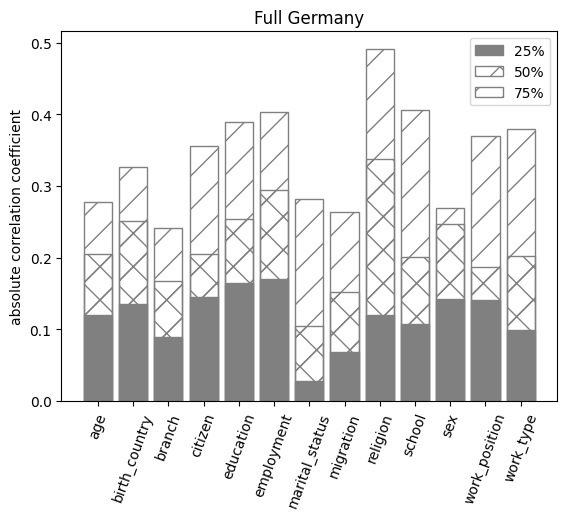

In [44]:
plt.bar(mycat1,catcor[3,:,0],edgecolor='gray',facecolor='gray',label='25%') 
plt.bar(mycat1,catcor[2,:,0],edgecolor='gray',facecolor='None',hatch='\\/', label='50%')  
plt.bar(mycat1,catcor[4,:,0],edgecolor='gray',facecolor='None',hatch='/', label='75%') 
plt.legend(loc="best") 
plt.ylabel("absolute correlation coefficient")
plt.xticks(rotation=70)
plt.title("Full Germany")

Text(0.5, 1.0, 'West Germany')

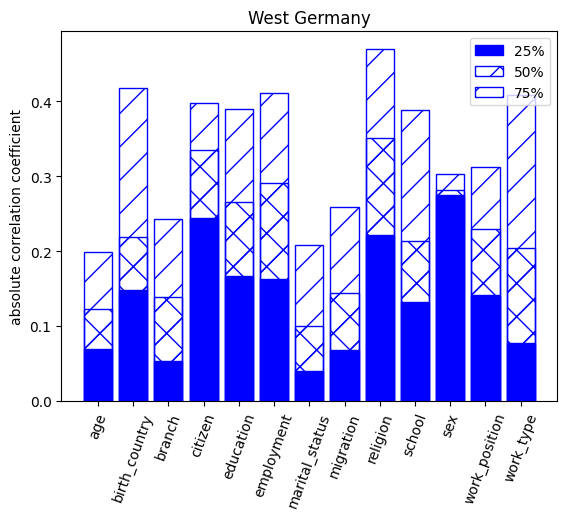

In [45]:
plt.bar(mycat1,catcor[3,:,1],edgecolor='blue',facecolor='blue',label='25%') 
plt.bar(mycat1,catcor[2,:,1],edgecolor='blue',facecolor='None',hatch='\\/', label='50%')  
plt.bar(mycat1,catcor[4,:,1],edgecolor='blue',facecolor='None',hatch='/', label='75%') 
plt.legend(loc="best") 
plt.ylabel("absolute correlation coefficient")
plt.xticks(rotation=70)
plt.title("West Germany")

Text(0.5, 1.0, 'East Germany')

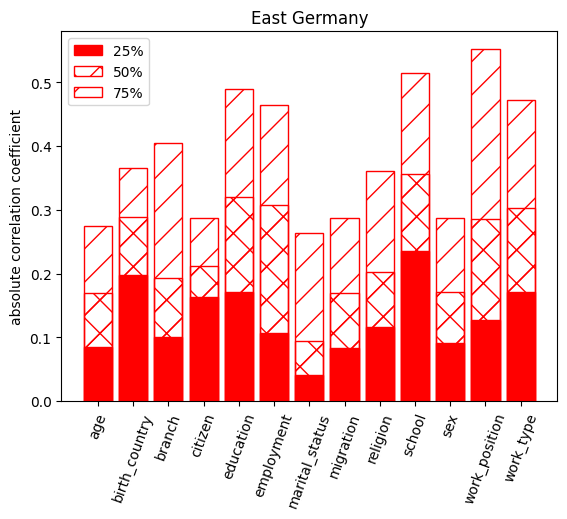

In [46]:
plt.bar(mycat1,catcor[3,:,2],edgecolor='red',facecolor='red',label='25%') 
plt.bar(mycat1,catcor[2,:,2],edgecolor='red',facecolor='None',hatch='\\/', label='50%')  
plt.bar(mycat1,catcor[4,:,2],edgecolor='red',facecolor='None',hatch='/', label='75%') 
plt.legend(loc="best") 
plt.ylabel("absolute correlation coefficient")
plt.xticks(rotation=70)
plt.title("East Germany")

As visible before religion is important, in addition work related factors and in the East the school level. Also sex factor are important in West Germany also sex has an enlarged correlation coefficient. 

We now look on the impact of a property relative to its share. First for voter properties. We do not plot total voters, because it is very similar to valid votes. 

in East Germany categories ['migration_60-69', 'migration_70-79', 'migration_80-89'] have [1. 2. 6.] non NULl values


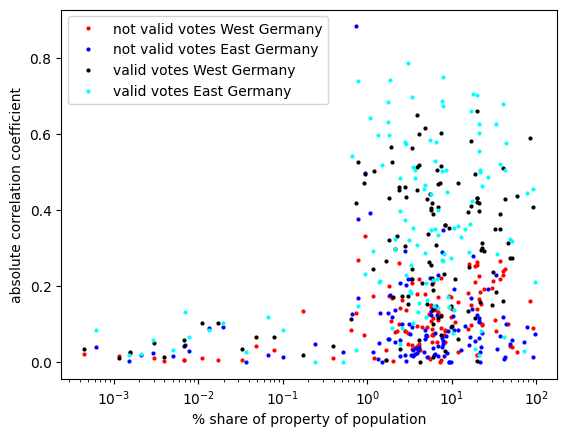

In [48]:
plt.plot(100*pop2[1,:,1],abs(corr1[1,:,1]),'o',ms=2,color='red',label='not valid votes West Germany') 
plt.plot(100*pop2[1,:,2],abs(corr1[1,:,2]),'o',ms=2,color='blue',label='not valid votes East Germany') 
plt.plot(100*pop2[1,:,1],abs(corr1[2,:,1]),'o',ms=2,color='black',label='valid votes West Germany') 
plt.plot(100*pop2[1,:,2],abs(corr1[2,:,2]),'o',ms=2,color='cyan',label='valid votes East Germany') 
plt.legend(loc="best")
plt.xlabel("% share of property of population")
plt.ylabel("absolute correlation coefficient")
plt.xscale("log")
#plt.yscale("log")
print(f"in East Germany categories {listg1b[67:70]} have {corr1[10,67:70,2]} non NULl values")

And now the parties seperately in West and East Germany. 

Text(0.5, 1.0, 'West Germany')

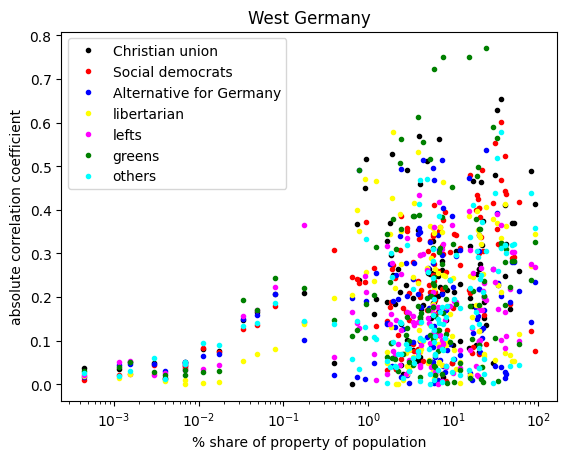

In [49]:
plt.plot(100*pop2[1,:,1],abs(corr1[3,:,1]),'o',ms=3,color='black',label='Christian union') 
plt.plot(100*pop2[1,:,1],abs(corr1[4,:,1]),'o',ms=3,color='red',label='Social democrats') 
plt.plot(100*pop2[1,:,1],abs(corr1[5,:,1]),'o',ms=3,color='blue',label='Alternative for Germany') 
plt.plot(100*pop2[1,:,1],abs(corr1[6,:,1]),'o',ms=3,color='yellow',label='libertarian') 
plt.plot(100*pop2[1,:,1],abs(corr1[7,:,1]),'o',ms=3,color='magenta',label='lefts') 
plt.plot(100*pop2[1,:,1],abs(corr1[8,:,1]),'o',ms=3,color='green',label='greens') 
plt.plot(100*pop2[1,:,1],abs(corr1[9,:,1]),'o',ms=3,color='cyan',label='others') 
plt.legend(loc="best")
plt.xlabel("% share of property of population")
plt.ylabel("absolute correlation coefficient")
plt.xscale("log")
plt.title("West Germany")

Text(0.5, 1.0, 'East Germany')

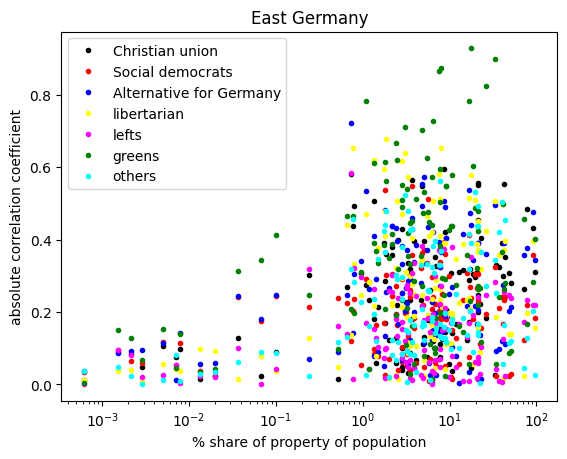

In [50]:
plt.plot(100*pop2[1,:,2],abs(corr1[3,:,2]),'o',ms=3,color='black',label='Christian union') 
plt.plot(100*pop2[1,:,2],abs(corr1[4,:,2]),'o',ms=3,color='red',label='Social democrats') 
plt.plot(100*pop2[1,:,2],abs(corr1[5,:,2]),'o',ms=3,color='blue',label='Alternative for Germany') 
plt.plot(100*pop2[1,:,2],abs(corr1[6,:,2]),'o',ms=3,color='yellow',label='libertarian') 
plt.plot(100*pop2[1,:,2],abs(corr1[7,:,2]),'o',ms=3,color='magenta',label='lefts') 
plt.plot(100*pop2[1,:,2],abs(corr1[8,:,2]),'o',ms=3,color='green',label='greens') 
plt.plot(100*pop2[1,:,2],abs(corr1[9,:,2]),'o',ms=3,color='cyan',label='others') 
plt.legend(loc="best")
plt.xlabel("% share of property of population")
plt.ylabel("absolute correlation coefficient")
plt.xscale("log")
plt.title("East Germany")

It is visible that very rare properties do not have strong correation. That does not mean that they are unimportant, but other factors are more important and dilute there signal. The large signal at 1% in east Germany especially for invalid votes, is not necessary real since that caused by only 6 comminities with one property.   There is probablyalso a decline above 80%, not surpirsing since with such a large fraction it is also more difficult to have alarge impact. 

Below we plot in log space. There it is visible, that seem to be an limit for small fractions. 

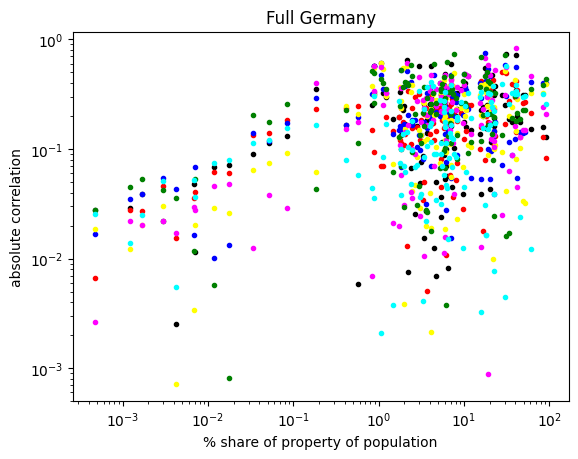

In [51]:
plt.plot(100*pop2[1,:,0],abs(corr1[3,:,0]),'o',ms=3,color='black',label='Christian union') 
plt.plot(100*pop2[1,:,0],abs(corr1[4,:,0]),'o',ms=3,color='red',label='Social democrats') 
plt.plot(100*pop2[1,:,0],abs(corr1[5,:,0]),'o',ms=3,color='blue',label='Alternative for Germany') 
plt.plot(100*pop2[1,:,0],abs(corr1[6,:,0]),'o',ms=3,color='yellow',label='libertarian') 
plt.plot(100*pop2[1,:,0],abs(corr1[7,:,0]),'o',ms=3,color='magenta',label='lefts') 
plt.plot(100*pop2[1,:,0],abs(corr1[8,:,0]),'o',ms=3,color='green',label='greens') 
plt.plot(100*pop2[1,:,0],abs(corr1[9,:,0]),'o',ms=3,color='cyan',label='others') 
#plt.legend(loc="best")
plt.xlabel("% share of property of population")
plt.ylabel("absolute correlation")
plt.title("Full Germany")
plt.xscale("log")
plt.yscale("log")

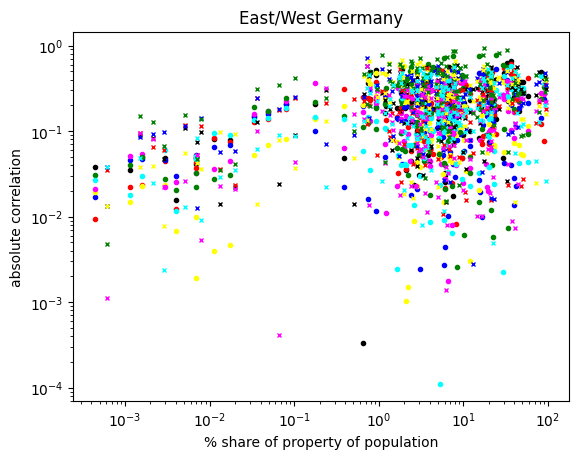

In [52]:
plt.plot(100*pop2[1,:,1],abs(corr1[3,:,1]),'o',ms=3,color='black',label='Christian union') 
plt.plot(100*pop2[1,:,1],abs(corr1[4,:,1]),'o',ms=3,color='red',label='Social democrats') 
plt.plot(100*pop2[1,:,1],abs(corr1[5,:,1]),'o',ms=3,color='blue',label='Alternative for Germany') 
plt.plot(100*pop2[1,:,1],abs(corr1[6,:,1]),'o',ms=3,color='yellow',label='libertarian') 
plt.plot(100*pop2[1,:,1],abs(corr1[7,:,1]),'o',ms=3,color='magenta',label='lefts') 
plt.plot(100*pop2[1,:,1],abs(corr1[8,:,1]),'o',ms=3,color='green',label='greens') 
plt.plot(100*pop2[1,:,1],abs(corr1[9,:,1]),'o',ms=3,color='cyan',label='others') 
plt.plot(100*pop2[1,:,2],abs(corr1[3,:,2]),'x',ms=3,color='black',label='Christian union') 
plt.plot(100*pop2[1,:,2],abs(corr1[4,:,2]),'x',ms=3,color='red',label='Social democrats') 
plt.plot(100*pop2[1,:,2],abs(corr1[5,:,2]),'x',ms=3,color='blue',label='Alternative for Germany') 
plt.plot(100*pop2[1,:,2],abs(corr1[6,:,2]),'x',ms=3,color='yellow',label='libertarian') 
plt.plot(100*pop2[1,:,2],abs(corr1[7,:,2]),'x',ms=3,color='magenta',label='lefts') 
plt.plot(100*pop2[1,:,2],abs(corr1[8,:,2]),'x',ms=3,color='green',label='greens') 
plt.plot(100*pop2[1,:,2],abs(corr1[9,:,2]),'x',ms=3,color='cyan',label='others') 
#plt.legend(loc="best")
plt.xlabel("% share of property of population")
plt.ylabel("absolute correlation")
plt.title("East/West Germany")
plt.xscale("log")
plt.yscale("log")

In [67]:
#probably omit since there are many plots
for i in range(len(listg1b)):
    print(f"{listg1b[i]} has share of {round(100*pop2[1,i,0],4)}% and median abs cor coev of {round(np.median(abs(corr1[:,i,0])),4)}")

male has share of 48.705% and median abs cor coev of 0.2652
female has share of 51.2951% and median abs cor coev of 0.2648
single_total has share of 40.3159% and median abs cor coev of 0.3116
single_male has share of 21.6761% and median abs cor coev of 0.2161
single_female has share of 18.6357% and median abs cor coev of 0.2977
married_total has share of 45.3006% and median abs cor coev of 0.142
married_male has share of 22.649% and median abs cor coev of 0.1453
married_female has share of 22.6499% and median abs cor coev of 0.1456
widowed_total has share of 7.0533% and median abs cor coev of 0.3942
widowed_male has share of 1.2105% and median abs cor coev of 0.3231
widowed_female has share of 5.8093% and median abs cor coev of 0.3753
divorced_total has share of 7.1386% and median abs cor coev of 0.3877
divorced_male has share of 3.0088% and median abs cor coev of 0.3362
divorced_female has share of 4.0952% and median abs cor coev of 0.3768
civil_union_total has share of 0.0833% and me

The smallest percetange are really small. Thus we are excluding ended civil unions. A related question is how different are the male/female parts of the total of the same property. It should not be used total, male and feamle at once because that would be double use. For civil union we just use the total because the number is low and it seems that just noise decreases all singal there, since most coeffeicent are larger when combined.

To decided the others we look on plots. Below we look on sex. Then feamle is just a mirror of male we display it by region instead. Because female is mirror we exclude it. We always do that for one property of one category because otherwise there would be perfect correlation which makes weights not interpretable. 

In practice  imperfect data makes it not perfect, but still too good for being useful. Often also low fractions of the remaining one still result in too good correlation of the remaining ones, thus we exclude more categories or summarize similar ones.  

Text(0, 0.5, 'correlation coefficient for male')

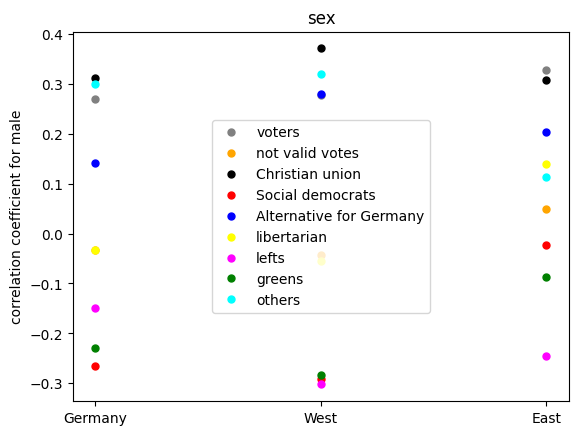

In [68]:
listf=['Germany','West','East']
plt.plot(listf[0:3],corr1[0,0,:],'o',ms=5,color='gray',label='voters') 
plt.plot(listf[0:3],corr1[1,0,:],'o',ms=5,color='orange',label='not valid votes') 
plt.plot(listf[0:3],corr1[3,0,:],'o',ms=5,color='black',label='Christian union') 
plt.plot(listf[0:3],corr1[4,0,:],'o',ms=5,color='red',label='Social democrats') 
plt.plot(listf[0:3],corr1[5,0,:],'o',ms=5,color='blue',label='Alternative for Germany') 
plt.plot(listf[0:3],corr1[6,0,:],'o',ms=5,color='yellow',label='libertarian') 
plt.plot(listf[0:3],corr1[7,0,:],'o',ms=5,color='magenta',label='lefts') 
plt.plot(listf[0:3],corr1[8,0,:],'o',ms=5,color='green',label='greens') 
plt.plot(listf[0:3],corr1[9,0,:],'o',ms=5,color='cyan',label='others') 
plt.legend(loc="best") 
plt.title("sex")
plt.ylabel("correlation coefficient for male")
#plt.xscale("log")
#plt.xlim(-0.5,16.5)


Now we plot to the coefficent for all marital status categories with enough data. 

(-1.8, 0.55)

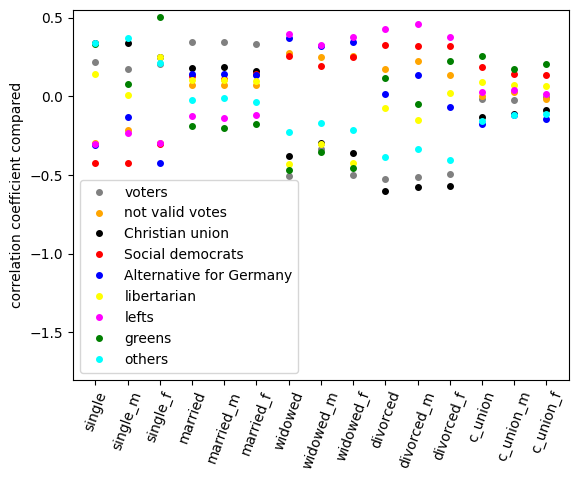

In [69]:
listpl1=['single', 'single_m', 'single_f', 'married', 'married_m', 'married_f', 'widowed', 'widowed_m', 'widowed_f', 'divorced', 'divorced_m', 'divorced_f', 'c_union', 'c_union_m', 'c_union_f']
plt.plot(listpl1,corr1[0,2:17,0],'o',ms=4,color='gray',label='voters') 
plt.plot(listpl1,corr1[1,2:17,0],'o',ms=4,color='orange',label='not valid votes') 
plt.plot(listpl1,(corr1[3,2:17,0]),'o',ms=4,color='black',label='Christian union') 
plt.plot(listpl1,corr1[4,2:17,0],'o',ms=4,color='red',label='Social democrats') 
plt.plot(listpl1,corr1[5,2:17,0],'o',ms=4,color='blue',label='Alternative for Germany') 
plt.plot(listpl1,corr1[6,2:17,0],'o',ms=4,color='yellow',label='libertarian') 
plt.plot(listpl1,corr1[7,2:17,0],'o',ms=4,color='magenta',label='lefts') 
plt.plot(listpl1,corr1[8,2:17,0],'o',ms=4,color='green',label='greens') 
plt.plot(listpl1,corr1[9,2:17,0],'o',ms=4,color='cyan',label='others') 
plt.legend(loc="best") #impove it, two boxes side by side 
#plt.xlabel("property number")
plt.xticks(rotation=70)
plt.ylabel("correlation coefficient compared")
plt.ylim(-1.8,0.55)

Since for single there are clear difference we separate by gender. In contrast it seems rather similar for married, therefore we use married total there. This does not necessary means it is the same but because married couples live usually together, census based analysis cannot separate them well. For widowed the coefficents are nearly always larger absolutely together than separated, thsu we use them together. That could be just caused by low numbers. In contrast there are some parties which have with clearly different trends for divorced, thus we separate them.  At the we omit civil union from the categories because since all together sum up to 100% it is already included.


We now look on the age groups. 

['total_18_24', 'male_18_24', 'female_18_24', 'total_25_29', 'male_25_29', 'female_25_29', 'total_30_39', 'male_30_39', 'female_30_39', 'total_40_49', 'male_40_49', 'female_40_49', 'total_50_64', 'male_50_64', 'female_50_64', 'total_65_74', 'male_65_74', 'female_65_74', 'total_75_and_older', 'male_75_and_older', 'female_75_and_older']


Text(0.5, 1.0, 'Full Germany')

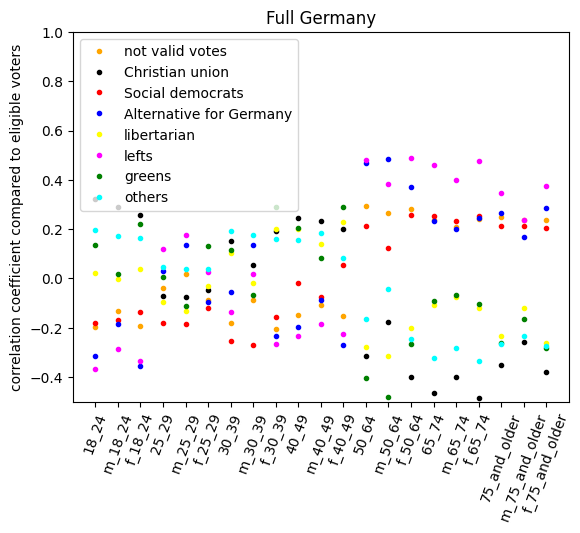

In [70]:
print(listg1b[26:47])
lista=['18_24', 'm_18_24', 'f_18_24', '25_29', 'm_25_29', 'f_25_29', '30_39', 'm_30_39', 'f_30_39', '40_49', 'm_40_49', 'f_40_49', '50_64', 'm_50_64', 'f_50_64', '65_74', 'm_65_74', 'f_65_74', '75_and_older', 'm_75_and_older', 'f_75_and_older']
plt.plot(lista,corr1[1,26:47,0],'o',ms=3,color='orange',label='not valid votes') 
plt.plot(lista,(corr1[3,26:47,0]),'o',ms=3,color='black',label='Christian union') 
plt.plot(lista,corr1[4,26:47,0],'o',ms=3,color='red',label='Social democrats') 
plt.plot(lista,corr1[5,26:47,0],'o',ms=3,color='blue',label='Alternative for Germany') 
plt.plot(lista,corr1[6,26:47,0],'o',ms=3,color='yellow',label='libertarian') 
plt.plot(lista,corr1[7,26:47,0],'o',ms=3,color='magenta',label='lefts') 
plt.plot(lista,corr1[8,26:47,0],'o',ms=3,color='green',label='greens') 
plt.plot(lista,corr1[9,26:47,0],'o',ms=3,color='cyan',label='others') 
plt.legend(loc="best") #too big improve add also labels and betetr symbols
#plt.xlabel("property number")
plt.ylabel("correlation coefficient compared to eligible voters")
plt.xticks(rotation=70)
plt.ylim(-0.5, 1)
#plt.xscale("log")
plt.title('Full Germany')



There are clear differences, but lets check whether they are also there when Germany is separated in East and West. 

Text(0.5, 1.0, 'West Germany')

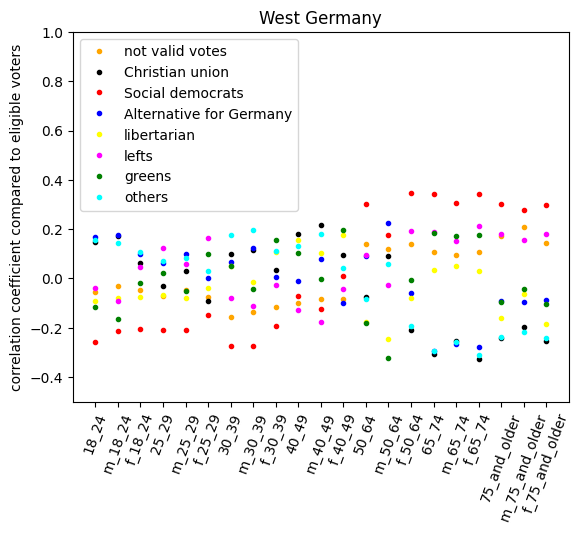

In [71]:
plt.plot(lista,corr1[1,26:47,1],'o',ms=3,color='orange',label='not valid votes') 
plt.plot(lista,(corr1[3,26:47,1]),'o',ms=3,color='black',label='Christian union') 
plt.plot(lista,corr1[4,26:47,1],'o',ms=3,color='red',label='Social democrats') 
plt.plot(lista,corr1[5,26:47,1],'o',ms=3,color='blue',label='Alternative for Germany') 
plt.plot(lista,corr1[6,26:47,1],'o',ms=3,color='yellow',label='libertarian') 
plt.plot(lista,corr1[7,26:47,1],'o',ms=3,color='magenta',label='lefts') 
plt.plot(lista,corr1[8,26:47,1],'o',ms=3,color='green',label='greens') 
plt.plot(lista,corr1[9,26:47,1],'o',ms=3,color='cyan',label='others') 
plt.legend(loc="best") #too big improve add also labels and betetr symbols
#plt.xlabel("property number")
plt.ylabel("correlation coefficient compared to eligible voters")
plt.xticks(rotation=70)
plt.ylim(-0.5, 1)
#plt.xscale("log")
plt.title('West Germany')
#still there although weaker, still different than what is usually found 

Since there are always some differences (least between 65 and 74) we use always the genders separately and discard the totals for the age groups.

Finally, we look on the citizen and religion properties

['citizen_german', 'birth_country_germany', 'birth_country_foreign', 'birth_country_eu27', 'birth_country_other_europe', 'birth_country_other_continents', 'birth_country_other', 'religion_catholic', 'religion_protestant', 'religion_other']


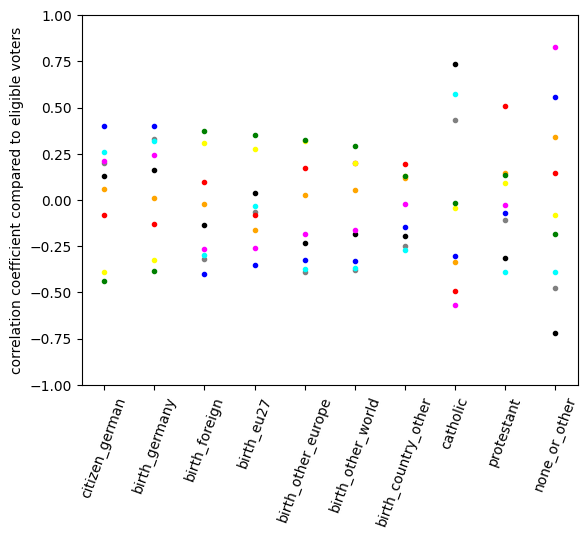

In [72]:
listb=['citizen_german', 'birth_germany', 'birth_foreign', 'birth_eu27', 'birth_other_europe', 'birth_other_world', 'birth_country_other', 'catholic', 'protestant', 'none_or_other']
plt.plot(listb,corr1[0,47:57,0],'o',ms=3,color='gray',label='voters') 
plt.plot(listb,corr1[1,47:57,0],'o',ms=3,color='orange',label='not valid votes') 
plt.plot(listb,(corr1[3,47:57,0]),'o',ms=3,color='black',label='Christian union') 
plt.plot(listb,corr1[4,47:57,0],'o',ms=3,color='red',label='Social democrats') 
plt.plot(listb,corr1[5,47:57,0],'o',ms=3,color='blue',label='Alternative for Germany') 
plt.plot(listb,corr1[6,47:57,0],'o',ms=3,color='yellow',label='libertarian') 
plt.plot(listb,corr1[7,47:57,0],'o',ms=3,color='magenta',label='lefts') 
plt.plot(listb,corr1[8,47:57,0],'o',ms=3,color='green',label='greens') 
plt.plot(listb,corr1[9,47:57,0],'o',ms=3,color='cyan',label='others') 
#plt.legend(loc="best") too big improve add also labels and betetr symbols
plt.ylabel("correlation coefficient compared to eligible voters")
plt.xticks(rotation=70)
#plt.xscale("log")
plt.ylim(-1,1)

print(listg1[47:57])

We discard citizen German since it is smaller than the birth country Germany and all voters should be citizens. We
exclude foreigen borth coiuntry since it is the negative of the former and use the eu27, other europe and other continents. We exclude other since it is unclear what is in it and the signal is small. All religions are kept since the have one of the largest signal. 

['migration_background_no', 'migration_background_yes', 'migration_background_foreign_total', 'migration_background_foreign_foreign_born', 'migration_background_foreign_german_born', 'migration_background_german_total', 'migration_background_german_foreign_born', 'migration_background_german_german_born', 'migration_background_german_german_born_mig_2parents', 'migration_background_german_german_born_mig_1parents']


(-0.5, 0.5)

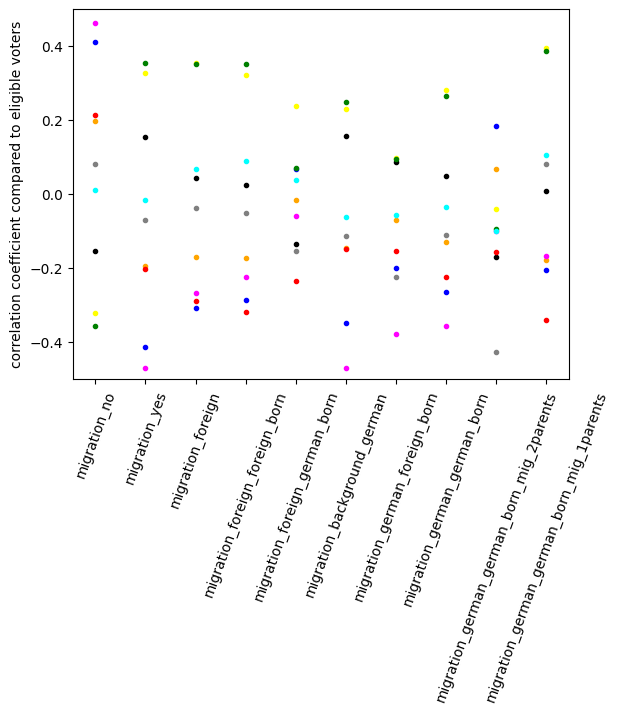

In [73]:
print(listg1b[57:67])
listm=['migration_no', 'migration_yes', 'migration_foreign', 'migration_foreign_foreign_born', 'migration_foreign_german_born', 'migration_background_german', 'migration_german_foreign_born', 'migration_german_german_born', 'migration_german_german_born_mig_2parents', 'migration_german_german_born_mig_1parents']

plt.plot(listm,corr1[0,57:67,0],'o',ms=3,color='gray',label='voters') 
plt.plot(listm,corr1[1,57:67,0],'o',ms=3,color='orange',label='not valid votes') 
plt.plot(listm,(corr1[3,57:67,0]),'o',ms=3,color='black',label='Christian union') 
plt.plot(listm,corr1[4,57:67,0],'o',ms=3,color='red',label='Social democrats') 
plt.plot(listm,corr1[5,57:67,0],'o',ms=3,color='blue',label='Alternative for Germany') 
plt.plot(listm,corr1[6,57:67,0],'o',ms=3,color='yellow',label='libertarian') 
plt.plot(listm,corr1[7,57:67,0],'o',ms=3,color='magenta',label='lefts') 
plt.plot(listm,corr1[8,57:67,0],'o',ms=3,color='green',label='greens') 
plt.plot(listm,corr1[9,57:67,0],'o',ms=3,color='cyan',label='others') 
#plt.legend(loc="best") too big improve add also labels and betetr symbols
plt.ylabel("correlation coefficient compared to eligible voters")
plt.xticks(rotation=70)
#plt.xscale("log")
plt.ylim(-0.5,0.5)
#AFP ger ger 2 parenets migration interesting russia germans? 

Further we discard some whose inclusion would lead too strong correlations between different features. Firstly, this is religion(other) which follows automatically when the other two are excluded. 
We also exclude divorced_female, because while in principlr we already exclude some features in the marital status category, they add up to so such a small number, that is practice there is still a very strong correlation without it. We choose divorced_female because its correlatio coefficients are most similar too civil union which domiantes the rests. 

In [74]:
print(listg1)
listg2=['male','single_male', 'single_female', 'married_total', 'widowed_total','divorced_male','male_18_24', 'female_18_24',  'male_25_29', 'female_25_29',  'male_30_39', 'female_30_39',  'male_40_49', 'female_40_49',  'male_50_64', 'female_50_64',  'male_65_74', 'female_65_74', 'male_75_and_older', 'female_75_and_older',  'birth_country_germany', 'birth_country_eu27', 'birth_country_other_europe', 'birth_country_other_continents',  'religion_catholic', 'religion_protestant']
print(len(listg2))
print(listg2)

['male', 'female', 'single_total', 'single_male', 'single_female', 'married_total', 'married_male', 'married_female', 'widowed_total', 'widowed_male', 'widowed_female', 'divorced_total', 'divorced_male', 'divorced_female', 'civil_union_total', 'civil_union_male', 'civil_union_female', 'civil_union_widowed_total', 'civil_union_widowed_male', 'civil_union_widowed_female', 'civil_union_divorced_total', 'civil_union_divorced_male', 'civil_union_divorved_female', 'not_specified_total', 'not_specified_male', 'not_specified_female', 'total_18_24', 'male_18_24', 'female_18_24', 'total_25_29', 'male_25_29', 'female_25_29', 'total_30_39', 'male_30_39', 'female_30_39', 'total_40_49', 'male_40_49', 'female_40_49', 'total_50_64', 'male_50_64', 'female_50_64', 'total_65_74', 'male_65_74', 'female_65_74', 'total_75_and_older', 'male_75_and_older', 'female_75_and_older', 'citizen_german', 'birth_country_germany', 'birth_country_foreign', 'birth_country_eu27', 'birth_country_other_europe', 'birth_count

Now we are selecting the units whoch have good data for all the selected properties. 

In [75]:
sel3=sel2.copy()
#get clean section and the use linear regression
for i in range(len(listg2)):
    sel3=sel3[(sel2[listg2[i]].isna()==False)]

/tmp/ipykernel_9794/1304716806.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sel3=sel3[(sel2[listg2[i]].isna()==False)]


In [76]:
print(len(sel2))
print(len(sel3))
print(sel2.population.sum())
print(sel3.population.sum())
print(sel2.population.min())
print(sel3.population.min())
print(sel2.population.median())
print(sel3.population.median())

5098
2535
71064974
61549224
55
55
5122.0
10798.0


In [77]:
#next is doing linear regression
#select properties of party, votes and valid votes are very similar thus only one and is now refernce, since usually the share is given to votes
listp2=['eligible_voters','not_valid_party_votes','christian_unions_party_votes','social_democrats_party_votes','alternative_for_germany_party_votes',
'libertarians_party_votes', 'lefts_party_votes','greens_party_votes','others_party_votes']
print(listp2)
#new reference is'valid_votes_party_votes'
#select features 
print(len(listg2))
feat=sel3.loc[:,[listg2[0],listg2[1]]]
print(sel3.loc[:,'population'])
feat.iloc[:,0]=feat.iloc[:,0]/sel3.loc[:,'population']*100
feat.iloc[:,1]=feat.iloc[:,1]/sel3.loc[:,'population']*100
for i in range(2,len(listg2)):
    feat[listg2[i]]=sel3.loc[:,[listg2[i]]]
    feat.iloc[:,i]=feat.iloc[:,i]/sel3.loc[:,'population']*100
print(feat)
#now the targets which are all of listp2
tar=sel3.loc[:,[listp2[0],listp2[1]]]
print(sel3.loc[:,'population'])
tar.iloc[:,0]=tar.iloc[:,0]/sel3.loc[:,'valid_party_votes']*100
tar.iloc[:,1]=tar.iloc[:,1]/sel3.loc[:,'valid_party_votes']*100
for i in range(2,len(listp2)):
    tar[listp2[i]]=sel3.loc[:,[listp2[i]]]
    tar.iloc[:,i]=tar.iloc[:,i]/sel3.loc[:,'valid_party_votes']*100
print(tar)

['eligible_voters', 'not_valid_party_votes', 'christian_unions_party_votes', 'social_democrats_party_votes', 'alternative_for_germany_party_votes', 'libertarians_party_votes', 'lefts_party_votes', 'greens_party_votes', 'others_party_votes']
26
0        82258
1       235782
2       210305
3        77249
4        12834
         ...  
5080      2290
5086      3800
5090      5024
5095     34090
5097     10964
Name: population, Length: 2535, dtype: int64
           male  single_male  single_female  married_total  widowed_total  \
0     49.276666    25.266843      20.542683      37.775049       7.162829   
1     48.139807    25.517639      23.426725      35.537064       6.149324   
2     47.470103    22.003281      20.085114      40.743206       7.579468   
3     48.816166    21.844943      18.198294      42.988259       7.908193   
4     49.579243    20.531401      15.412186      48.675393       8.563192   
...         ...          ...            ...            ...            ...   
5080  4

Now we split into train and test set with the usual share of 80 to 20. 

In [78]:

feat_train,feat_test,tar_train, tar_test= train_test_split(feat,tar,train_size=0.80, shuffle=True, random_state=1)
print(f"shape of features in train {feat_train.shape}")
print(f"shape of features in test {feat_test.shape}")
#normalize the features  should use standard scaler
norm_feat_train=feat_train.copy()
norm_feat_test=feat_test.copy()
print(feat_train)
statg2=np.zeros((2,len(listg2)))
m=feat_train.iloc[:,0].mean()
s=feat_train.iloc[:,0].std()
statg2[0,0]=m
statg2[1,0]=s
norm_feat_train.iloc[:,0]=(feat_train.iloc[:,0]-m)/s
norm_feat_test.iloc[:,0]=(feat_test.iloc[:,0]-m)/s
for i in range(1,len(listg2)):
    m=feat_train.iloc[:,i].mean()
    s=feat_train.iloc[:,i].std()
    norm_feat_train.iloc[:,i]=(feat_train.iloc[:,i]-m)/s
    norm_feat_test.iloc[:,i]=(feat_test.iloc[:,i]-m)/s
    statg2[0,i]=m
    statg2[1,i]=s
print(norm_feat_test.mean())
print(norm_feat_test.std())
print(np.round(statg2.T,3))
print(feat_train)
print(statg2.T)

shape of features in train (2028, 26)
shape of features in test (507, 26)
           male  single_male  single_female  married_total  widowed_total  \
3117  49.257922    21.660650      19.574809      50.020056       4.813478   
2717  47.434991    20.292246      18.634614      47.639249       6.386990   
3367  49.123805    20.584888      16.306327      49.681384       6.804734   
679   48.804033    20.324314      17.547197      48.599553       6.961815   
3682  50.596002    20.905923      15.936182      51.494590       6.088392   
...         ...          ...            ...            ...            ...   
1346  48.884043    20.023089      16.534120      48.447922       8.004105   
1222  48.090975    19.923845      17.045727      46.934925       8.054612   
1601  48.700565    20.112994      18.003766      51.035782       5.499058   
341   50.065269    22.698303      17.730170      48.729171       6.895493   
1545  49.768672    20.183410      16.292135      52.602445       5.361864   

 

In [79]:
coefs=np.zeros((feat_test.shape[1]+1,len(listp2)+1))
coefs[:,9]=np.arange(0,feat_test.shape[1]+1,1)
predte=np.zeros((feat_test.shape[0],len(listp2)))
predtr=np.zeros((feat_train.shape[0],len(listp2)))
statlin=np.zeros((7,len(listp2)))
statlin[6,:]=np.arange(0,9,1)
for i in range(len(listp2)):
    print(i)
    reg = LinearRegression().fit(norm_feat_train, tar_train.iloc[:,i]) #fit results seem to be bad
    coefs[0:feat_test.shape[1],i]=reg.coef_
    print(reg.coef_)
    coefs[feat_test.shape[1],i]=reg.intercept_
    predtr[:,i]=reg.predict(norm_feat_train)    
    predte[:,i]=reg.predict(norm_feat_test)
    statlin[0,i]=tar_train.iloc[:,i].mean()
    statlin[1,i]=tar_train.iloc[:,i].std()  
    statlin[2,i]=np.std(tar_train.iloc[:,i]-predtr[:,i])   
    statlin[3,i]=tar_test.iloc[:,i].mean()
    statlin[4,i]=tar_test.iloc[:,i].std()  
    statlin[5,i]=np.std(tar_test.iloc[:,i]-predte[:,i])     
print(np.round(statlin.T,3))    

0
[-1.97784872  1.13922629 -2.3270987  -1.22600736  4.47812765  1.92093717
  0.11949717 -0.03911587 -0.06219367 -0.76189952  0.26860777 -2.36954543
  0.47021611 -2.34567707  0.89015451 -1.85716323 -0.05437276 -1.7243911
 -1.09284638 -2.47797232 -1.55202972 -0.68675956  1.58356345  1.37220428
 -4.39052823 -3.30968574]
1
[-0.07280023  0.07153944 -0.02965829  0.08441921  0.11611455  0.06644071
 -0.02480088  0.02594945  0.02333321 -0.00821071  0.02393371 -0.05435198
  0.06110948 -0.03232709  0.08592527 -0.01482712 -0.03933131 -0.02149847
  0.08345676 -0.09907581 -0.17505391 -0.12694293 -0.02995782  0.01242343
 -0.16103334 -0.09062492]
2
[ 0.53495447  0.60802301  1.08321606  1.50230729  1.16724081 -0.54906539
  0.05183843 -0.39058628 -0.32691222 -0.46259074  0.01013688 -0.21841504
 -0.21469909 -0.23886393 -0.12471065 -0.69009643  0.4998164  -0.04999227
 -0.95504463  0.1410248   0.59655207  1.05473766 -0.63905458  0.58961008
  5.18452301  1.46449047]
3
[-1.46899989 -1.84619849 -3.1057034  -2

We now plot the standard deviation over the full data set and the one after subtracting the predictions. 

['eligible_voters', 'not_valid_party_votes', 'christian_unions_party_votes', 'social_democrats_party_votes', 'alternative_for_germany_party_votes', 'libertarians_party_votes', 'lefts_party_votes', 'greens_party_votes', 'others_party_votes']


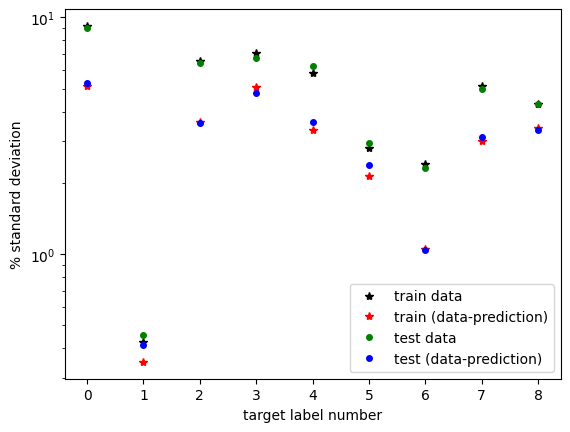

In [80]:
print(listp2)
plt.plot(statlin[6],statlin[1],'*',ms=6,color='black',label='train data') 
plt.plot(statlin[6],statlin[2],'*',ms=6,color='red',label='train (data-prediction)') 
plt.plot(statlin[6],statlin[4],'o',ms=4,color='green',label='test data') 
plt.plot(statlin[6],statlin[5],'o',ms=4,color='blue',label='test (data-prediction)') 
plt.legend(loc="best")
plt.ylabel("% standard deviation")
plt.xlabel("target label number")
plt.yscale("log")
#does not change after normnalization

['male', 'single_male', 'single_female', 'married_total', 'widowed_total', 'divorced_male', 'male_18_24', 'female_18_24', 'male_25_29', 'female_25_29', 'male_30_39', 'female_30_39', 'male_40_49', 'female_40_49', 'male_50_64', 'female_50_64', 'male_65_74', 'female_65_74', 'male_75_and_older', 'female_75_and_older', 'birth_country_germany', 'birth_country_eu27', 'birth_country_other_europe', 'birth_country_other_continents', 'religion_catholic', 'religion_protestant']
[ 1.09059856 -2.14247328  0.03913335 -3.99150226 -3.71152633 -1.55381866
 -0.22439529  0.36011715 -0.51401698  0.50934753 -0.68339533  0.98316695
 -0.31776934  1.40759231 -0.80257702  1.00458699  0.43921122  0.59053092
  0.62575073  1.07911969 -0.9400112   0.13979605 -0.03864712 -0.18202773
  0.19328362  1.38645447 11.91005623]


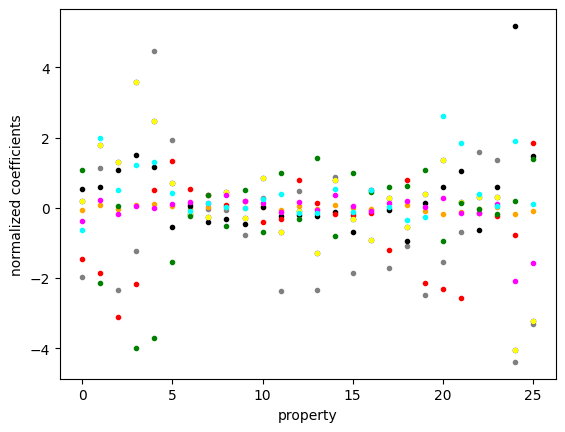

In [81]:
print(listg2)
plt.plot(coefs[0:26,9],coefs[0:26,0],'o',ms=3,color='gray',label=f'{listp2[0]}') 
plt.plot(coefs[0:26,9],coefs[0:26,1],'o',ms=3,color='orange',label=f'{listp2[1]}')
plt.plot(coefs[0:26,9],coefs[0:26,2],'o',ms=3,color='black',label=f'{listp2[2]}') 
plt.plot(coefs[0:26,9],coefs[0:26,3],'o',ms=3,color='red',label=f'{listp2[3]}')
plt.plot(coefs[0:26,9],coefs[0:26,4],'o',ms=3,color='blue',label=f'{listp2[4]}') 
plt.plot(coefs[0:26,9],coefs[0:26,4],'o',ms=3,color='yellow',label=f'{listp2[5]}')
plt.plot(coefs[0:26,9],coefs[0:26,6],'o',ms=3,color='magenta',label=f'{listp2[6]}') 
plt.plot(coefs[0:26,9],coefs[0:26,7],'o',ms=3,color='green',label=f'{listp2[7]}')
plt.plot(coefs[0:26,9],coefs[0:26,8],'o',ms=3,color='cyan',label=f'{listp2[8]}')
#plt.legend(loc="best")
plt.ylabel("normalized coefficients")
plt.xlabel("property")
#plt.xscale("log")
#plt.yscale("log")
#something wrong all religion positive for chrsiatin is wrong 
#now somewhat more differences and more seem irrelevant (all the ince which have small shares)
#values cahnge a lot here, prediction goodness less
print(coefs[0:29,7])
#still big signal in first part  civil union is too small part for omitting for stable fits 

(2028, 9)


Text(0.5, 0, 'prediction')

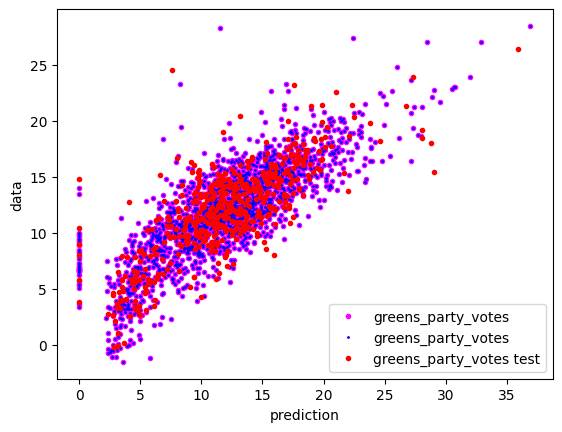

In [82]:
print(np.shape(predtr))
pg=coefs[26,7]+np.matmul(norm_feat_train,coefs[0:26,7]) #prediction works and does what it should but still strange numnbers
plt.plot(tar_train.iloc[:,7],predtr[:,7],'o',ms=3,color='magenta',label=f'{listp2[7]}') 
plt.plot(tar_train.iloc[:,7],pg,'o',ms=1,color='blue',label=f'{listp2[7]}') 
plt.plot(tar_test.iloc[:,7],predte[:,7],'o',ms=3,color='red',label=f'{listp2[7]} test') 
plt.legend(loc="best")
plt.ylabel("data")
plt.xlabel("prediction")
#prediction o.k. but seem that minors are not well done 
#seems like only get 

We try now to use Lasso L1 regularization to reduce the number of features. We do this for each label (party) separately, since it is not expected that the same are important for all. As criterain we use that the score in the test set is thhe same as in the origal sample. It is expected when excluding a few the scores first improves. However, that should be caused by random overfitting on training, the true perfamnace should be reached when the score is again the same as at the beginning. 

In [83]:
#first just doing for one at a time without a function

pars=np.zeros((8,40,len(listp2)))
for i in range(40):
    pars[0,i,0]=0.0001*1.35**i

    
for j in range(len(listp2)):
    print(listp2[j])
    for i in range(np.shape(pars)[1]):
        print(pars[0,i,0])
        reg = Lasso(alpha=pars[0,i,0],max_iter=1000).fit(norm_feat_train, tar_train.iloc[:,j]) 
        #print(reg.coef_)
        pars[1,i,j]=np.count_nonzero(reg.coef_!=0)
        print(np.where(reg.coef_==0,listg2, 0))
        predtrl=reg.predict(norm_feat_train)    
        predtel=reg.predict(norm_feat_test)
        pars[2,i,j]=tar_train.iloc[:,j].mean()
        pars[3,i,j]=tar_train.iloc[:,j].std()  
        pars[4,i,j]=np.std(tar_train.iloc[:,j]-predtrl)   
        pars[5,i,j]=tar_test.iloc[:,j].mean()
        pars[6,i,j]=tar_test.iloc[:,j].std()  
        pars[7,i,j]=np.std(tar_test.iloc[:,j]-predtel)
#somehow not converged     and increase does not help, likely correlation problem 
print(pars[1,:,:])
#too often of first part, need to exclude one there 

eligible_voters
0.0001
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00013500000000000003
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00018225000000000004
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00024603750000000006
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00033215062500000013
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.0004484033437500002
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.0006053445140625002
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.0008172150939843753
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '

['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00024603750000000006
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00033215062500000013
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.0004484033437500002
['0' 'single_male' '0' '0' '0' '0' '0' '0' '0' 'female_25_29' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0']
0.0006053445140625002
['0' 'single_male' '0' '0' '0' '0' '0' '0' '0' 'female_25_29' '0' '0' '0'
 '0' '0' 'female_50_64' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0']
0.0008172150939843753
['0' 'single_male' '0' '0' '0' '0' '0' '0' '0' 'female_25_29' '0' '0' '0'
 '0' '0' 'female_50_64' '0' 'female_65_74' '0' '0' '0' '0' '0' '0' '0' '0']
0.001103240376878907
['male' '0' '0' '0' '0' '0' '0' '0' '0' 'female_25_29' '0' '0' '0' '0' '0'
 'female_50_64' '0' 'female_65_74' '0' '0' '0' '0'
 'b

['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00013500000000000003
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00018225000000000004
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00024603750000000006
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00033215062500000013
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.0004484033437500002
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.0006053445140625002
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.0008172150939843753
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0'

['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00013500000000000003
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00018225000000000004
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00024603750000000006
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00033215062500000013
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.0004484033437500002
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.0006053445140625002
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.0008172150939843753
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0'

['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00013500000000000003
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00018225000000000004
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00024603750000000006
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00033215062500000013
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.0004484033437500002
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.0006053445140625002
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.0008172150939843753
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0'

['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00013500000000000003
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00018225000000000004
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00024603750000000006
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00033215062500000013
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.0004484033437500002
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.0006053445140625002
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.0008172150939843753
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0'

['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00033215062500000013
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.0004484033437500002
['0' '0' '0' 'married_total' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0']
0.0006053445140625002
['0' '0' '0' 'married_total' 'widowed_total' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0']
0.0008172150939843753
['0' '0' '0' 'married_total' 'widowed_total' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0']
0.001103240376878907
['0' '0' '0' 'married_total' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0']
0.0014893745087865243
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.0020106555868618084
['0' '0' '0' '0' '0' '0' 

['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00013500000000000003
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00018225000000000004
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00024603750000000006
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00033215062500000013
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.0004484033437500002
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.0006053445140625002
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.0008172150939843753
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0'

['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00018225000000000004
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00024603750000000006
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.00033215062500000013
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.0004484033437500002
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.0006053445140625002
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.0008172150939843753
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0']
0.001103240376878907
['0' '0' '0' '0' '0' '0' '0' '0' '0' 'female_25_29' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0

['eligible_voters', 'not_valid_party_votes', 'christian_unions_party_votes', 'social_democrats_party_votes', 'alternative_for_germany_party_votes', 'libertarians_party_votes', 'lefts_party_votes', 'greens_party_votes', 'others_party_votes']


(-0.01, 0.005)

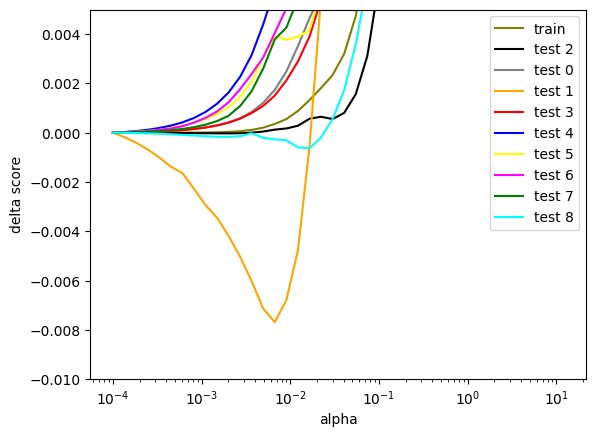

In [84]:
print(listp2)
plt.plot(pars[0,:,0],pars[4,:,2]/pars[3,:,2]-pars[4,0,2]/pars[3,0,2],'-',ms=1,color='olive',label='train')
plt.plot(pars[0,:,0],pars[7,:,2]/pars[6,:,2]-pars[7,0,2]/pars[6,0,2],'-',ms=1,color='black',label='test 2')
plt.plot(pars[0,:,0],pars[7,:,0]/pars[6,:,0]-pars[7,0,0]/pars[6,0,0],'-',ms=1,color='gray',label='test 0')
plt.plot(pars[0,:,0],pars[7,:,1]/pars[6,:,1]-pars[7,0,1]/pars[6,0,1],'-',ms=1,color='orange',label='test 1')
plt.plot(pars[0,:,0],pars[7,:,3]/pars[6,:,3]-pars[7,0,3]/pars[6,0,3],'-',ms=1,color='red',label='test 3')
plt.plot(pars[0,:,0],pars[7,:,4]/pars[6,:,4]-pars[7,0,4]/pars[6,0,4],'-',ms=1,color='blue',label='test 4')
plt.plot(pars[0,:,0],pars[7,:,5]/pars[6,:,5]-pars[7,0,5]/pars[6,0,5],'-',ms=1,color='yellow',label='test 5')
plt.plot(pars[0,:,0],pars[7,:,6]/pars[6,:,6]-pars[7,0,6]/pars[6,0,6],'-',ms=1,color='magenta',label='test 6')
plt.plot(pars[0,:,0],pars[7,:,7]/pars[6,:,7]-pars[7,0,7]/pars[6,0,7],'-',ms=1,color='green',label='test 7')
plt.plot(pars[0,:,0],pars[7,:,8]/pars[6,:,8]-pars[7,0,8]/pars[6,0,8],'-',ms=1,color='cyan',label='test 8')
plt.legend(loc="best")
plt.xlabel("alpha")
plt.ylabel("delta score")
plt.xscale("log")
plt.ylim(-0.01,0.005)
#some limit above to exclude maybe more subsets automatic ofr just repat

(-0.01, 0.005)

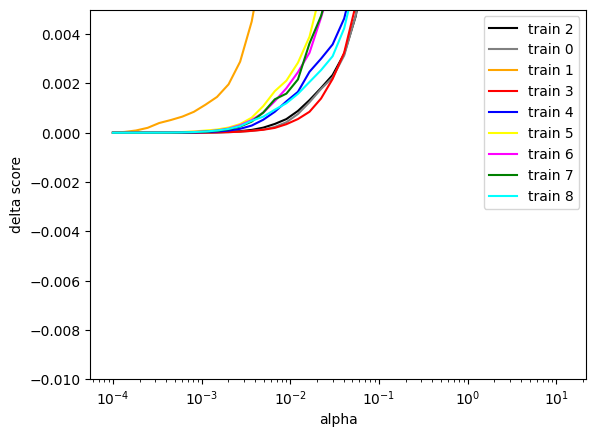

In [85]:
plt.plot(pars[0,:,0],pars[4,:,2]/pars[3,:,2]-pars[4,0,2]/pars[3,0,2],'-',ms=1,color='black',label='train 2')
plt.plot(pars[0,:,0],pars[4,:,0]/pars[3,:,0]-pars[4,0,0]/pars[3,0,0],'-',ms=1,color='gray',label='train 0')
plt.plot(pars[0,:,0],pars[4,:,1]/pars[3,:,1]-pars[4,0,1]/pars[3,0,1],'-',ms=1,color='orange',label='train 1')
plt.plot(pars[0,:,0],pars[4,:,3]/pars[3,:,3]-pars[4,0,3]/pars[3,0,3],'-',ms=1,color='red',label='train 3')
plt.plot(pars[0,:,0],pars[4,:,4]/pars[3,:,4]-pars[4,0,4]/pars[3,0,4],'-',ms=1,color='blue',label='train 4')
plt.plot(pars[0,:,0],pars[4,:,5]/pars[3,:,5]-pars[4,0,5]/pars[3,0,5],'-',ms=1,color='yellow',label='train 5')
plt.plot(pars[0,:,0],pars[4,:,6]/pars[3,:,6]-pars[4,0,6]/pars[3,0,6],'-',ms=1,color='magenta',label='train 6')
plt.plot(pars[0,:,0],pars[4,:,7]/pars[3,:,7]-pars[4,0,7]/pars[3,0,7],'-',ms=1,color='green',label='train 7')
plt.plot(pars[0,:,0],pars[4,:,8]/pars[3,:,8]-pars[4,0,8]/pars[3,0,8],'-',ms=1,color='cyan',label='train 8')
plt.legend(loc="best")
plt.xlabel("alpha")
plt.ylabel("delta score")
plt.xscale("log")
plt.ylim(-0.01,0.005)

In [86]:
for i in range(len(listp2)):
    print(listp2[i])
    delt=abs(pars[7,:,i]/pars[6,:,i]-pars[7,0,i]/pars[6,0,i]-0.002)
    s=np.argsort(delt)
    print(f"it are {int(pars[1,s[0],i])} features")
    reg = Lasso(alpha=pars[0,s[0],0],max_iter=1000).fit(norm_feat_train, tar_train.iloc[:,i]) 
    print(f"needed features are {np.where(reg.coef_!=0,listg2, 0)}")
#number of features varies a lot, without not ideal probably    

eligible_voters
it are 26 features
needed features are ['male' 'single_male' 'single_female' 'married_total' 'widowed_total'
 'divorced_male' 'male_18_24' 'female_18_24' 'male_25_29' 'female_25_29'
 'male_30_39' 'female_30_39' 'male_40_49' 'female_40_49' 'male_50_64'
 'female_50_64' 'male_65_74' 'female_65_74' 'male_75_and_older'
 'female_75_and_older' 'birth_country_germany' 'birth_country_eu27'
 'birth_country_other_europe' 'birth_country_other_continents'
 'religion_catholic' 'religion_protestant']
not_valid_party_votes
it are 26 features
needed features are ['male' 'single_male' 'single_female' 'married_total' 'widowed_total'
 'divorced_male' 'male_18_24' 'female_18_24' 'male_25_29' 'female_25_29'
 'male_30_39' 'female_30_39' 'male_40_49' 'female_40_49' 'male_50_64'
 'female_50_64' 'male_65_74' 'female_65_74' 'male_75_and_older'
 'female_75_and_older' 'birth_country_germany' 'birth_country_eu27'
 'birth_country_other_europe' 'birth_country_other_continents'
 'religion_catholic' 're

In [87]:
#now really feature omitting define function which does it for one label 
#gets features_train, labels_train, features_test, labels_train
def omit1(feat_train,tar_train,feat_test,tar_test,listg):
    statlind4=np.zeros((11,feat_train.shape[1]))
    statlind4[0,:]=np.arange(0,feat_train.shape[1],1)
    for i in range(feat_train.shape[1]):
        norm_feat_train_d4=feat_train.drop(labels=listg[i],axis=1).copy()
        norm_feat_test_d4=feat_test.drop(labels=listg[i],axis=1).copy()
        reg = LinearRegression().fit(norm_feat_train_d4, tar_train) 
        predtr=reg.predict(norm_feat_train_d4)    
        predte=reg.predict(norm_feat_test_d4)
        statlind4[1,i]=tar_train.mean()
        statlind4[2,i]=tar_train.std()  
        statlind4[3,i]=np.std(tar_train-predtr)   
        statlind4[4,i]=tar_test.mean()
        statlind4[5,i]=tar_test.std()  
        statlind4[6,i]=np.std(tar_test-predte)   
        statlind4[7,i]=statlind4[3,i]/statlind4[2,i]
        statlind4[8,i]=statlind4[6,i]/statlind4[5,i]
        statlind4[9,i]=0.5*statlind4[7,i]+0.5*statlind4[8,i]
        statlind4[10,i]=0.8*statlind4[7,i]+0.2*statlind4[8,i]        
    return statlind4

In [88]:
res=omit1(norm_feat_train,tar_train.iloc[:,0],norm_feat_test,tar_test.iloc[:,0],listg2)
print(res[7:11])

[[0.5591548  0.55823916 0.56006248 0.55821002 0.56666508 0.56039381
  0.55806857 0.55802519 0.55803256 0.55957173 0.55819196 0.57010687
  0.55846961 0.56844966 0.55913332 0.56284463 0.55802551 0.56114228
  0.56036131 0.5624136  0.55872117 0.55867684 0.56082792 0.56071359
  0.59812769 0.58801316]
 [0.58898457 0.58586913 0.58074888 0.5834804  0.60812365 0.59102082
  0.58507075 0.58451336 0.58533053 0.58513403 0.58564179 0.59283185
  0.58341485 0.5904295  0.59056362 0.59159261 0.58466073 0.58743127
  0.58335232 0.59907127 0.58638314 0.58579189 0.58640464 0.58889277
  0.64075633 0.62657438]
 [0.57406968 0.57205415 0.57040568 0.57084521 0.58739437 0.57570731
  0.57156966 0.57126928 0.57168155 0.57235288 0.57191688 0.58146936
  0.57094223 0.57943958 0.57484847 0.57721862 0.57134312 0.57428678
  0.57185681 0.58074243 0.57255216 0.57223436 0.57361628 0.57480318
  0.61944201 0.60729377]
 [0.56512075 0.56376516 0.56419976 0.5632641  0.5749568  0.56651921
  0.563469   0.56332282 0.56349215 0.5646

In [89]:
#as before but add iterations to it and which is minimized 
def itomit(feat_train,tar_train,feat_test,tar_test,listg,x,y):
    its=np.zeros((11,x))
    print("iteration 0")
    res=omit1(feat_train,tar_train,feat_test,tar_test,listg)
    s=np.argmin(res[y,:])
    print(f"omitted is {listg[s]}")
    its[:,0]=res[:,s]
    listd2=[listg[s]]
    listg2=listg.copy()
    listg2.remove(listg[s])
    feat_train2=feat_train.drop(labels=listg[s],axis=1).copy()
    feat_test2=feat_test.drop(labels=listg[s],axis=1).copy()  
    feat_train=feat_train2.copy()
    feat_test=feat_test2.copy() 
    for j in range (1,x):
        print(f"iteration {j}")
        res=omit1(feat_train,tar_train,feat_test,tar_test,listg2)
        s=np.argmin(res[y,:])
        print(f"omitted is {listg2[s]}")
        its[:,j]=res[:,s]
        listd2.append(listg2[s])
        listg2=listg2.copy()
        listg2.remove(listg2[s])
        feat_train2=feat_train.drop(labels=listd2[j],axis=1).copy()
        feat_test2=feat_test.drop(labels=listd2[j],axis=1).copy() 
        feat_train=feat_train2.copy()
        feat_test=feat_test2.copy() 
    return listd2, its


In [90]:
#now all targets at once
#input features_train, targets_train, features_test, targets_test, how many features to omitted, 
#what fraction test  used 
def itomita(feat_train3,tar_train2,feat_test3,tar_test2,listg,x,y):
    its=np.zeros((11,int(x+1),tar_train2.shape[1]))
    lista=[]
    for i in range(tar_train2.shape[1]):
        #copy because they will be changed by removing features
        feat_test=feat_test3.copy()        
        feat_train=feat_train3.copy()
        tar_train=tar_train2.iloc[:,i]
        tar_test=tar_test2.iloc[:,i]
        print(f"target {i}")
        #nothing omit case
        reg = LinearRegression().fit(feat_train, tar_train) 
        predtr=reg.predict(feat_train)    
        predte=reg.predict(feat_test)
        its[1,0,i]=tar_train.mean()
        its[2,0,i]=tar_train.std()  
        its[3,0,i]=np.std(tar_train-predtr)   
        its[4,0,i]=tar_test.mean()
        its[5,0,i]=tar_test.std()  
        its[6,0,i]=np.std(tar_test-predte)   
        its[7,0,i]=its[3,0,i]/its[2,0,i]
        its[8,0,i]=its[6,0,i]/its[5,0,i]
        its[9,0,i]=0.5*its[7,0,i]+0.5*its[8,0,i]
        its[10,0,i]=0.8*its[7,0,i]+0.2*its[8,0,i]
        print("iteration 0")
        res=omit1(feat_train,tar_train,feat_test,tar_test,listg)
        s=np.argmin(res[7,:]*y+res[8,:]*(1-y))
        print(f"omitted is {listg[s]}")
        its[:,1,i]=res[:,s]
        listd2=[listg[s]]
        listg2=listg.copy()
        listg2.remove(listg[s])
        feat_train2=feat_train.drop(labels=listg[s],axis=1).copy()
        feat_test2=feat_test.drop(labels=listg[s],axis=1).copy()  
        feat_train=feat_train2.copy()
        feat_test=feat_test2.copy() 
        for j in range (1,x):
            print(f"iteration {j}")
            res=omit1(feat_train,tar_train,feat_test,tar_test,listg2)
            s=np.argmin(res[7,:]*y+res[8,:]*(1-y))
            print(f"omitted is {listg2[s]}")
            its[:,j+1,i]=res[:,s]
            listd2.append(listg2[s])
            listg2=listg2.copy()
            listg2.remove(listg2[s])
            feat_train2=feat_train.drop(labels=listd2[j],axis=1).copy()
            feat_test2=feat_test.drop(labels=listd2[j],axis=1).copy() 
            feat_train=feat_train2.copy()
            feat_test=feat_test2.copy() 
        lista.append(listd2)
    return lista, its


In [91]:
#apply on all the targets
listd0,its0=itomit(norm_feat_train,tar_train.iloc[:,0],norm_feat_test,tar_test.iloc[:,0],listg2,25,9)
print(listd0)
print(its0)
listd1,its1=itomit(norm_feat_train,tar_train.iloc[:,1],norm_feat_test,tar_test.iloc[:,1],listg2,25,9)
print(listd0)
print(its1)
listd2,its2=itomit(norm_feat_train,tar_train.iloc[:,2],norm_feat_test,tar_test.iloc[:,2],listg2,25,9)
print(listd0)
print(its2)
listd3,its3=itomit(norm_feat_train,tar_train.iloc[:,3],norm_feat_test,tar_test.iloc[:,3],listg2,25,9)
print(listd3)
print(its3)
listd4,its4=itomit(norm_feat_train,tar_train.iloc[:,4],norm_feat_test,tar_test.iloc[:,4],listg2,25,9)
print(listd4)
print(its4)
listd5,its5=itomit(norm_feat_train,tar_train.iloc[:,5],norm_feat_test,tar_test.iloc[:,5],listg2,25,9)
print(listd5)
print(its5)
listd6,its6=itomit(norm_feat_train,tar_train.iloc[:,6],norm_feat_test,tar_test.iloc[:,6],listg2,25,9)
print(listd6)
print(its6)
listd7,its7=itomit(norm_feat_train,tar_train.iloc[:,7],norm_feat_test,tar_test.iloc[:,7],listg2,25,9)
print(listd7)
print(its7)
listd8,its8=itomit(norm_feat_train,tar_train.iloc[:,8],norm_feat_test,tar_test.iloc[:,8],listg2,25,9)
print(listd8)
print(its8)

iteration 0
omitted is single_female
iteration 1
omitted is male_40_49
iteration 2
omitted is female_18_24
iteration 3
omitted is male_30_39
iteration 4
omitted is male_18_24
iteration 5
omitted is male_65_74
iteration 6
omitted is married_total
iteration 7
omitted is female_25_29
iteration 8
omitted is male
iteration 9
omitted is single_male
iteration 10
omitted is male_25_29
iteration 11
omitted is birth_country_germany
iteration 12
omitted is birth_country_eu27
iteration 13
omitted is male_50_64
iteration 14
omitted is female_50_64
iteration 15
omitted is male_75_and_older
iteration 16
omitted is female_40_49
iteration 17
omitted is female_30_39
iteration 18
omitted is female_75_and_older
iteration 19
omitted is birth_country_other_europe
iteration 20
omitted is divorced_male
iteration 21
omitted is female_65_74
iteration 22
omitted is religion_protestant
iteration 23
omitted is religion_catholic
iteration 24
omitted is birth_country_other_continents
['single_female', 'male_40_49', 

omitted is birth_country_other_continents
iteration 1
omitted is divorced_male
iteration 2
omitted is male_25_29
iteration 3
omitted is birth_country_germany
iteration 4
omitted is female_65_74
iteration 5
omitted is male_18_24
iteration 6
omitted is female_75_and_older
iteration 7
omitted is male
iteration 8
omitted is male_30_39
iteration 9
omitted is male_50_64
iteration 10
omitted is female_40_49
iteration 11
omitted is female_30_39
iteration 12
omitted is female_18_24
iteration 13
omitted is male_40_49
iteration 14
omitted is male_65_74
iteration 15
omitted is single_male
iteration 16
omitted is single_female
iteration 17
omitted is widowed_total
iteration 18
omitted is married_total
iteration 19
omitted is birth_country_eu27
iteration 20
omitted is male_75_and_older
iteration 21
omitted is birth_country_other_europe
iteration 22
omitted is female_50_64
iteration 23
omitted is female_25_29
iteration 24
omitted is religion_protestant
['single_female', 'male_40_49', 'female_18_24', 

omitted is male_25_29
iteration 1
omitted is male
iteration 2
omitted is female_25_29
iteration 3
omitted is female_18_24
iteration 4
omitted is female_50_64
iteration 5
omitted is female_30_39
iteration 6
omitted is male_40_49
iteration 7
omitted is male_18_24
iteration 8
omitted is birth_country_eu27
iteration 9
omitted is birth_country_other_europe
iteration 10
omitted is birth_country_other_continents
iteration 11
omitted is female_65_74
iteration 12
omitted is male_75_and_older
iteration 13
omitted is female_75_and_older
iteration 14
omitted is male_65_74
iteration 15
omitted is birth_country_germany
iteration 16
omitted is divorced_male
iteration 17
omitted is single_female
iteration 18
omitted is female_40_49
iteration 19
omitted is male_30_39
iteration 20
omitted is male_50_64
iteration 21
omitted is single_male
iteration 22
omitted is married_total
iteration 23
omitted is widowed_total
iteration 24
omitted is religion_protestant
['male_25_29', 'male', 'female_25_29', 'female_1

omitted is birth_country_other_europe
iteration 1
omitted is male_65_74
iteration 2
omitted is single_female
iteration 3
omitted is female_75_and_older
iteration 4
omitted is female_30_39
iteration 5
omitted is female_40_49
iteration 6
omitted is married_total
iteration 7
omitted is divorced_male
iteration 8
omitted is birth_country_eu27
iteration 9
omitted is female_50_64
iteration 10
omitted is female_25_29
iteration 11
omitted is male_40_49
iteration 12
omitted is male_18_24
iteration 13
omitted is male_75_and_older
iteration 14
omitted is male_30_39
iteration 15
omitted is female_65_74
iteration 16
omitted is single_male
iteration 17
omitted is male
iteration 18
omitted is birth_country_other_continents
iteration 19
omitted is female_18_24
iteration 20
omitted is male_50_64
iteration 21
omitted is birth_country_germany
iteration 22
omitted is male_25_29
iteration 23
omitted is widowed_total
iteration 24
omitted is religion_protestant
['birth_country_other_europe', 'male_65_74', 'si

omitted is male_75_and_older
iteration 1
omitted is birth_country_other_europe
iteration 2
omitted is male_25_29
iteration 3
omitted is male_40_49
iteration 4
omitted is birth_country_other_continents
iteration 5
omitted is female_25_29
iteration 6
omitted is female_18_24
iteration 7
omitted is married_total
iteration 8
omitted is divorced_male
iteration 9
omitted is single_female
iteration 10
omitted is religion_protestant
iteration 11
omitted is male_30_39
iteration 12
omitted is female_50_64
iteration 13
omitted is male_18_24
iteration 14
omitted is female_65_74
iteration 15
omitted is male
iteration 16
omitted is female_40_49
iteration 17
omitted is female_75_and_older
iteration 18
omitted is male_65_74
iteration 19
omitted is male_50_64
iteration 20
omitted is female_30_39
iteration 21
omitted is widowed_total
iteration 22
omitted is single_male
iteration 23
omitted is birth_country_eu27
iteration 24
omitted is birth_country_germany
['male_75_and_older', 'birth_country_other_europ

In [92]:
#now all at once # seems to work 
listda,itsa=itomita(norm_feat_train,tar_train,norm_feat_test,tar_test,listg2,25,0.5)
print(listda)
print(itsa)

target 0
iteration 0
omitted is single_female
iteration 1
omitted is male_40_49
iteration 2
omitted is female_18_24
iteration 3
omitted is male_30_39
iteration 4
omitted is male_18_24
iteration 5
omitted is male_65_74
iteration 6
omitted is married_total
iteration 7
omitted is female_25_29
iteration 8
omitted is male
iteration 9
omitted is single_male
iteration 10
omitted is male_25_29
iteration 11
omitted is birth_country_germany
iteration 12
omitted is birth_country_eu27
iteration 13
omitted is male_50_64
iteration 14
omitted is female_50_64
iteration 15
omitted is male_75_and_older
iteration 16
omitted is female_40_49
iteration 17
omitted is female_30_39
iteration 18
omitted is female_75_and_older
iteration 19
omitted is birth_country_other_europe
iteration 20
omitted is divorced_male
iteration 21
omitted is female_65_74
iteration 22
omitted is religion_protestant
iteration 23
omitted is religion_catholic
iteration 24
omitted is birth_country_other_continents
target 1
iteration 0
om

omitted is religion_protestant
iteration 11
omitted is male_30_39
iteration 12
omitted is female_50_64
iteration 13
omitted is male_18_24
iteration 14
omitted is female_65_74
iteration 15
omitted is male
iteration 16
omitted is female_40_49
iteration 17
omitted is female_75_and_older
iteration 18
omitted is male_65_74
iteration 19
omitted is male_50_64
iteration 20
omitted is female_30_39
iteration 21
omitted is widowed_total
iteration 22
omitted is single_male
iteration 23
omitted is birth_country_eu27
iteration 24
omitted is birth_country_germany
[['single_female', 'male_40_49', 'female_18_24', 'male_30_39', 'male_18_24', 'male_65_74', 'married_total', 'female_25_29', 'male', 'single_male', 'male_25_29', 'birth_country_germany', 'birth_country_eu27', 'male_50_64', 'female_50_64', 'male_75_and_older', 'female_40_49', 'female_30_39', 'female_75_and_older', 'birth_country_other_europe', 'divorced_male', 'female_65_74', 'religion_protestant', 'religion_catholic', 'birth_country_other_con

In [93]:
feat_trainb,feat_testb,tar_trainb, tar_testb= train_test_split(feat,tar,train_size=0.80, shuffle=True, random_state=4)
#normalize the features  should use standard scaler or not
norm_feat_trainb=feat_trainb.copy()
norm_feat_testb=feat_testb.copy()
statg2b=np.zeros((2,len(listg2)))
for i in range(len(listg2)):
    m=feat_trainb.iloc[:,i].mean()
    s=feat_trainb.iloc[:,i].std()
    norm_feat_trainb.iloc[:,i]=(feat_trainb.iloc[:,i]-m)/s
    norm_feat_testb.iloc[:,i]=(feat_testb.iloc[:,i]-m)/s
    statg2b[0,i]=m
    statg2b[1,i]=s   

In [94]:
listdab,itsab=itomita(norm_feat_trainb,tar_trainb,norm_feat_testb,tar_testb,listg2,25,0.5)
print(listdab)

target 0
iteration 0
omitted is male_30_39
iteration 1
omitted is married_total
iteration 2
omitted is male_65_74
iteration 3
omitted is female_18_24
iteration 4
omitted is male_18_24
iteration 5
omitted is male_40_49
iteration 6
omitted is male_25_29
iteration 7
omitted is birth_country_germany
iteration 8
omitted is birth_country_eu27
iteration 9
omitted is male_75_and_older
iteration 10
omitted is male_50_64
iteration 11
omitted is single_female
iteration 12
omitted is male
iteration 13
omitted is female_25_29
iteration 14
omitted is female_50_64
iteration 15
omitted is female_40_49
iteration 16
omitted is female_65_74
iteration 17
omitted is female_30_39
iteration 18
omitted is female_75_and_older
iteration 19
omitted is birth_country_other_continents
iteration 20
omitted is divorced_male
iteration 21
omitted is single_male
iteration 22
omitted is religion_protestant
iteration 23
omitted is religion_catholic
iteration 24
omitted is birth_country_other_europe
target 1
iteration 0
om

omitted is birth_country_other_europe
iteration 12
omitted is male_30_39
iteration 13
omitted is male_18_24
iteration 14
omitted is female_25_29
iteration 15
omitted is married_total
iteration 16
omitted is female_18_24
iteration 17
omitted is male_65_74
iteration 18
omitted is male_75_and_older
iteration 19
omitted is female_50_64
iteration 20
omitted is female_30_39
iteration 21
omitted is widowed_total
iteration 22
omitted is single_male
iteration 23
omitted is birth_country_eu27
iteration 24
omitted is birth_country_germany
[['male_30_39', 'married_total', 'male_65_74', 'female_18_24', 'male_18_24', 'male_40_49', 'male_25_29', 'birth_country_germany', 'birth_country_eu27', 'male_75_and_older', 'male_50_64', 'single_female', 'male', 'female_25_29', 'female_50_64', 'female_40_49', 'female_65_74', 'female_30_39', 'female_75_and_older', 'birth_country_other_continents', 'divorced_male', 'single_male', 'religion_protestant', 'religion_catholic', 'birth_country_other_europe'], ['female_6

Text(0, 0.5, 'test score')

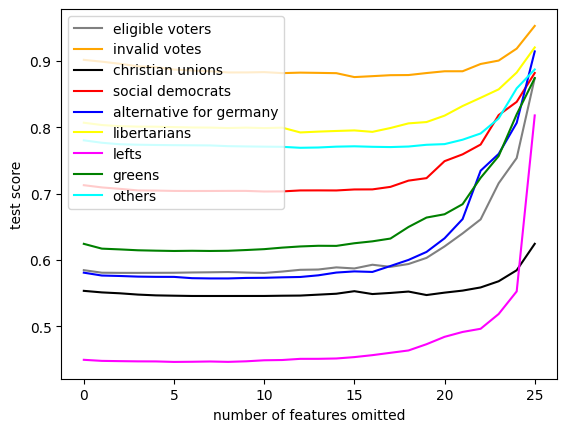

In [95]:
omit=np.arange(1,26,1)
omitb=np.arange(0,26,1)
listp4=['eligible voters','invalid votes','christian unions', 'social democrats', 'alternative for germany', 'libertarians', 'lefts', 'greens', 'others']
plt.plot(omitb,itsa[8,:,0],'-',ms=1,color='gray',label=listp4[0])
plt.plot(omitb,itsa[8,:,1],'-',ms=1,color='orange',label=listp4[1])
plt.plot(omitb,itsa[8,:,2],'-',ms=1,color='black',label=listp4[2])
plt.plot(omitb,itsa[8,:,3],'-',ms=1,color='red',label=listp4[3])
plt.plot(omitb,itsa[8,:,4],'-',ms=1,color='blue',label=listp4[4])
plt.plot(omitb,itsa[8,:,5],'-',ms=1,color='yellow',label=listp4[5])
plt.plot(omitb,itsa[8,:,6],'-',ms=1,color='magenta',label=listp4[6])
plt.plot(omitb,itsa[8,:,7],'-',ms=1,color='green',label=listp4[7])
plt.plot(omitb,itsa[8,:,8],'-',ms=1,color='cyan',label=listp4[8])
plt.legend(loc="best")
plt.xlabel("number of features omitted")
plt.ylabel("test score")
#plt.xscale("log")
#plt.ylim(-0.01,0.005)
#o.k. maybe more partitation of data? 

(-0.027, 0.05)

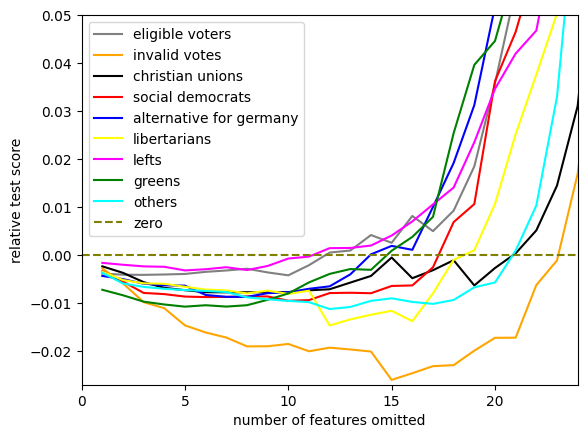

In [96]:

plt.plot(omit,itsa[8,1:26,0]-itsa[8,0,0],'-',ms=1,color='gray',label=listp4[0])
plt.plot(omit,itsa[8,1:26,1]-itsa[8,0,1],'-',ms=1,color='orange',label=listp4[1])
plt.plot(omit,itsa[8,1:,2]-itsa[8,0,2],'-',ms=1,color='black',label=listp4[2])
plt.plot(omit,itsa[8,1:,3]-itsa[8,0,3],'-',ms=1,color='red',label=listp4[3])
plt.plot(omit,itsa[8,1:,4]-itsa[8,0,4],'-',ms=1,color='blue',label=listp4[4])
plt.plot(omit,itsa[8,1:,5]-itsa[8,0,5],'-',ms=1,color='yellow',label=listp4[5])
plt.plot(omit,itsa[8,1:,6]-itsa[8,0,6],'-',ms=1,color='magenta',label=listp4[6])
plt.plot(omit,itsa[8,1:,7]-itsa[8,0,7],'-',ms=1,color='green',label=listp4[7])
plt.plot(omit,itsa[8,1:,8]-itsa[8,0,8],'-',ms=1,color='cyan',label=listp4[8])
plt.axhline(y=0, color='olive', linestyle='--', label='zero')
plt.legend(loc="best")
plt.xlabel("number of features omitted")
plt.ylabel("relative test score")
plt.xlim(0,24)
plt.ylim(-0.027, 0.05)



(-0.027, 0.05)

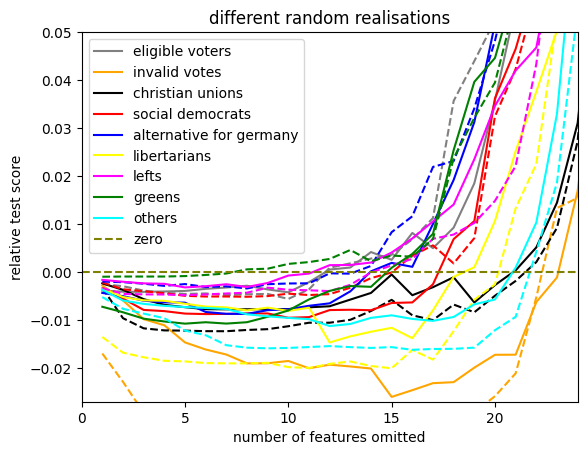

In [97]:
plt.plot(omit,itsa[8,1:26,0]-itsa[8,0,0],'-',ms=1,color='gray',label=listp4[0])
plt.plot(omit,itsab[8,1:26,0]-itsab[8,0,0],'--',ms=1,color='gray')
plt.plot(omit,itsa[8,1:26,1]-itsa[8,0,1],'-',ms=1,color='orange',label=listp4[1])
plt.plot(omit,itsab[8,1:,1]-itsab[8,0,1],'--',ms=1,color='orange')
plt.plot(omit,itsa[8,1:,2]-itsa[8,0,2],'-',ms=1,color='black',label=listp4[2])
plt.plot(omit,itsab[8,1:,2]-itsab[8,0,2],'--',ms=1,color='black')
plt.plot(omit,itsa[8,1:,3]-itsa[8,0,3],'-',ms=1,color='red',label=listp4[3])
plt.plot(omit,itsab[8,1:,3]-itsab[8,0,3],'--',ms=1,color='red')
plt.plot(omit,itsa[8,1:,4]-itsa[8,0,4],'-',ms=1,color='blue',label=listp4[4])
plt.plot(omit,itsab[8,1:,4]-itsab[8,0,4],'--',ms=1,color='blue')
plt.plot(omit,itsa[8,1:,5]-itsa[8,0,5],'-',ms=1,color='yellow',label=listp4[5])
plt.plot(omit,itsab[8,1:,5]-itsab[8,0,5],'--',ms=1,color='yellow')
plt.plot(omit,itsa[8,1:,6]-itsa[8,0,6],'-',ms=1,color='magenta',label=listp4[6])
plt.plot(omit,itsab[8,1:,6]-itsab[8,0,6],'--',ms=1,color='magenta')
plt.plot(omit,itsa[8,1:,7]-itsa[8,0,7],'-',ms=1,color='green',label=listp4[7])
plt.plot(omit,itsab[8,1:,7]-itsab[8,0,7],'--',ms=1,color='green')
plt.plot(omit,itsa[8,1:,8]-itsa[8,0,8],'-',ms=1,color='cyan',label=listp4[8])
plt.plot(omit,itsab[8,1:,8]-itsab[8,0,8],'--',ms=1,color='cyan')
plt.axhline(y=0, color='olive', linestyle='--', label='zero')
plt.legend(loc="best")
plt.xlabel("number of features omitted")
plt.ylabel("relative test score")
plt.title("different random realisations")
plt.xlim(0,24)
plt.ylim(-0.027, 0.05)



In our fit we omit always the feature without which the combined score (average of test and train) improves most. In all cases the score improves first indicating that there was overfitting. The amount varies a lot. For eligle voters after only 7 features the score is again as large as before. For all others at least 11 features can be omitted without decreasing the performcance on test, 21 in case of others. 

In [98]:
#function to run a number of random realisations
#for now no summarizing results yet
def random_rel(feat,tar,listg,x,y,z):
    its=np.zeros((11,int(x+1),tar.shape[1],int(z)))
    lista=[]
    for j in range(z):
        print(f"random realisation {j}")
        feat_train2,feat_test2,tar_train2, tar_test2= train_test_split(feat,tar,train_size=0.80, shuffle=True, random_state=(int(j)))
        norm_feat_trainb=feat_train2.copy()
        norm_feat_testb=feat_test2.copy()

        for i in range(norm_feat_trainb.shape[1]):
            m=feat_train2.iloc[:,i].mean()
            s=feat_train2.iloc[:,i].std()
            norm_feat_trainb.iloc[:,i]=(feat_train2.iloc[:,i]-m)/s
            norm_feat_testb.iloc[:,i]=(feat_test2.iloc[:,i]-m)/s
        listdab,itsab=itomita(norm_feat_trainb,tar_trainb,norm_feat_testb,tar_testb,listg2,x,y)    
        its[:,:,:,j]=itsab
        lista.append(listdab)
    return its, lista        

Now we run several random realisations. We use only test as metric, the averaging of several will cause that also train is considered.

In [99]:
#was done before with 20 ransom realisation now here in with just two important results are loaded as pickled
randomscore,randomlist=random_rel(feat,tar,listg2,25,0,2)
with open('randomscore2.pickle', 'wb') as f:
    # Pickle 
    pickle.dump(randomscore, f, pickle.HIGHEST_PROTOCOL)
with open('randomlist2.pickle', 'wb') as f:
    # Pickle 
    pickle.dump(randomlist, f, pickle.HIGHEST_PROTOCOL)    

random realisation 0
target 0
iteration 0
omitted is female_40_49
iteration 1
omitted is male_30_39
iteration 2
omitted is male_75_and_older
iteration 3
omitted is birth_country_germany
iteration 4
omitted is birth_country_eu27
iteration 5
omitted is female_25_29
iteration 6
omitted is male_40_49
iteration 7
omitted is birth_country_other_continents
iteration 8
omitted is female_65_74
iteration 9
omitted is single_female
iteration 10
omitted is male_65_74
iteration 11
omitted is male_50_64
iteration 12
omitted is religion_catholic
iteration 13
omitted is religion_protestant
iteration 14
omitted is birth_country_other_europe
iteration 15
omitted is male_25_29
iteration 16
omitted is female_50_64
iteration 17
omitted is divorced_male
iteration 18
omitted is female_75_and_older
iteration 19
omitted is female_18_24
iteration 20
omitted is male_18_24
iteration 21
omitted is male
iteration 22
omitted is single_male
iteration 23
omitted is widowed_total
iteration 24
omitted is married_total
t

omitted is single_female
iteration 11
omitted is religion_protestant
iteration 12
omitted is religion_catholic
iteration 13
omitted is birth_country_other_europe
iteration 14
omitted is birth_country_other_continents
iteration 15
omitted is male_40_49
iteration 16
omitted is female_30_39
iteration 17
omitted is divorced_male
iteration 18
omitted is married_total
iteration 19
omitted is male_30_39
iteration 20
omitted is birth_country_eu27
iteration 21
omitted is female_25_29
iteration 22
omitted is birth_country_germany
iteration 23
omitted is male
iteration 24
omitted is female_18_24
random realisation 1
target 0
iteration 0
omitted is female_65_74
iteration 1
omitted is male_50_64
iteration 2
omitted is female_75_and_older
iteration 3
omitted is female_25_29
iteration 4
omitted is birth_country_other_europe
iteration 5
omitted is birth_country_eu27
iteration 6
omitted is female_40_49
iteration 7
omitted is religion_catholic
iteration 8
omitted is single_male
iteration 9
omitted is wi

omitted is widowed_total
iteration 23
omitted is female_30_39
iteration 24
omitted is married_total
target 8
iteration 0
omitted is female_40_49
iteration 1
omitted is male_75_and_older
iteration 2
omitted is single_female
iteration 3
omitted is widowed_total
iteration 4
omitted is female_25_29
iteration 5
omitted is birth_country_other_europe
iteration 6
omitted is birth_country_germany
iteration 7
omitted is religion_catholic
iteration 8
omitted is religion_protestant
iteration 9
omitted is male_25_29
iteration 10
omitted is divorced_male
iteration 11
omitted is single_male
iteration 12
omitted is married_total
iteration 13
omitted is birth_country_eu27
iteration 14
omitted is male_30_39
iteration 15
omitted is female_75_and_older
iteration 16
omitted is birth_country_other_continents
iteration 17
omitted is female_65_74
iteration 18
omitted is female_18_24
iteration 19
omitted is female_50_64
iteration 20
omitted is female_30_39
iteration 21
omitted is male_18_24
iteration 22
omitte

In [100]:
#loading the 20 realisations results
with open('randomlist1.pickle', 'rb') as f:
    # unpickle
    randomlist = pickle.load(f)
with open('randomscore1.pickle', 'rb') as f:
    # unpickle
    randomscore = pickle.load(f)    
print(randomlist)

[[['female_40_49', 'male_30_39', 'male_75_and_older', 'birth_country_germany', 'birth_country_eu27', 'female_25_29', 'male_40_49', 'birth_country_other_continents', 'female_65_74', 'single_female', 'male_65_74', 'male_50_64', 'religion_catholic', 'religion_protestant', 'birth_country_other_europe', 'male_25_29', 'female_50_64', 'divorced_male', 'female_75_and_older', 'female_18_24', 'male_18_24', 'male', 'single_male', 'widowed_total', 'married_total'], ['birth_country_other_europe', 'female_40_49', 'male_18_24', 'male_50_64', 'religion_catholic', 'female_65_74', 'female_25_29', 'birth_country_germany', 'birth_country_eu27', 'birth_country_other_continents', 'single_female', 'married_total', 'female_50_64', 'female_30_39', 'divorced_male', 'male_40_49', 'female_75_and_older', 'single_male', 'male', 'widowed_total', 'male_30_39', 'male_25_29', 'religion_protestant', 'male_75_and_older', 'male_65_74'], ['female_40_49', 'birth_country_other_europe', 'female_25_29', 'female_30_39', 'male_2

In [101]:
#Figure where it goes above 0 again
a=its0[8,:]-statlin[5,0]/statlin[4,0]
count=np.zeros((len(listp2)+1,len(listg2)))
print(f"for {listp4[0]}")
for i in range(len(a)-1):
    if a[i]<0 and a[i+1]>0:
        print(f"excluded are {i} properties")
        print(f"delta score with them/with 1 more are {a[i:i+2]}")
        print(f"excluded are {listd0[0:i+1]}")
        for j in range(i+1):
            for k in range(len(listg2)):
                if listg2[k]==listd0[j]:
                    count[0,k]=1
        print(count[0])       
 
  
a=its1[8,:]-statlin[5,1]/statlin[4,1]
print(f"for {listp4[1]}")
for i in range(len(a)-1):
    if a[i]<0 and a[i+1]>0:
        print(f"excluded are {i} properties")
        print(f"delta score with them/with 1 more are {a[i:i+2]}")
        print(f"excluded are {listd1[0:i+1]}")
        for j in range(i+1):
            for k in range(len(listg2)):
                if listg2[k]==listd1[j]:
                    count[1,k]=1
        print(count[1])       
         
        
a=its2[8,:]-statlin[5,2]/statlin[4,2]
print(f"for {listp4[2]}")
for i in range(len(a)-1):
    if a[i]<0 and a[i+1]>0:
        print(f"excluded are {i} properties")
        print(f"delta score with them/with 1 more are {a[i:i+2]}")
        print(f"excluded are {listd2[0:i+1]}")     
        for j in range(i+1):
            for k in range(len(listg2)):
                if listg2[k]==listd2[j]:
                    count[2,k]=1
        print(count[2])       
x=3
a=its3[8,:]-statlin[5,x]/statlin[4,x]
print(f"for {listp4[x]}")
for i in range(len(a)-1):
    if a[i]<0 and a[i+1]>0:
        print(f"excluded are {i} properties")
        print(f"delta score with them/with 1 more are {a[i:i+2]}")
        print(f"excluded are {listd3[0:i+1]}")  
        for j in range(i+1):
            for k in range(len(listg2)):
                if listg2[k]==listd3[j]:
                    count[4,k]=1
        print(count[3])       
      
x=4
a=its4[8,:]-statlin[5,x]/statlin[4,x]
print(f"for {listp4[x]}")
for i in range(len(a)-1):
    if a[i]<0 and a[i+1]>0:
        print(f"excluded are {i} properties")
        print(f"delta score with them/with 1 more are {a[i:i+2]}")
        print(f"excluded are {listd4[0:i+1]}")   
        for j in range(i+1):
            for k in range(len(listg2)):
                if listg2[k]==listd4[j]:
                    count[4,k]=1
        print(count[4])       
        
x=5
a=its5[8,:]-statlin[5,x]/statlin[4,x]
print(f"for {listp4[x]}")
for i in range(len(a)-1):
    if a[i]<0 and a[i+1]>0:
        print(f"excluded are {i} properties")
        print(f"delta score with them/with 1 more are {a[i:i+2]}")
        print(f"excluded are {listd5[0:i+1]}")  
        for j in range(i+1):
            for k in range(len(listg2)):
                if listg2[k]==listd5[j]:
                    count[5,k]=1
        print(count[5])       
         
x=6
a=its6[8,:]-statlin[5,x]/statlin[4,x]
print(f"for {listp4[x]}")
for i in range(len(a)-1):
    if a[i]<0 and a[i+1]>0:
        print(f"excluded are {i} properties")
        print(f"delta score with them/with 1 more are {a[i:i+2]}")
        print(f"excluded are {listd6[0:i+1]}")  
        for j in range(i+1):
            for k in range(len(listg2)):
                if listg2[k]==listd6[j]:
                    count[x,k]=1
        print(count[x])       
       
x=7
a=its7[8,:]-statlin[5,x]/statlin[4,x]
print(f"for {listp4[x]}")
for i in range(len(a)-1):
    if a[i]<0 and a[i+1]>0:
        print(f"excluded are {i} properties")
        print(f"delta score with them/with 1 more are {a[i:i+2]}")
        print(f"excluded are {listd7[0:i+1]}")  
        for j in range(i+1):
            for k in range(len(listg2)):
                if listg2[k]==listd7[j]:
                    count[x,k]=1
        print(count[x])       
      
x=8
a=its8[8,:]-statlin[5,x]/statlin[4,x]
print(f"for {listp4[x]}")
for i in range(len(a)-1):
    if a[i]<0 and a[i+1]>0:
        print(f"excluded are {i} properties")
        print(f"delta score with them/with 1 more are {a[i:i+2]}")
        print(f"excluded are {listd8[0:i+1]}")  
        for j in range(i+1):
            for k in range(len(listg2)):
                if listg2[k]==listd7[j]:
                    count[x,k]=1
        print(count[x])             

for eligible voters
excluded are 10 properties
delta score with them/with 1 more are [-0.00209779  0.0005326 ]
excluded are ['single_female', 'male_40_49', 'female_18_24', 'male_30_39', 'male_18_24', 'male_65_74', 'married_total', 'female_25_29', 'male', 'single_male', 'male_25_29']
[1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
for invalid votes
excluded are 22 properties
delta score with them/with 1 more are [-0.00110929  0.01693874]
excluded are ['male_65_74', 'male_30_39', 'birth_country_germany', 'female_50_64', 'widowed_total', 'married_total', 'single_male', 'female_18_24', 'female_25_29', 'male_18_24', 'divorced_male', 'female_75_and_older', 'male', 'female_65_74', 'male_75_and_older', 'male_25_29', 'birth_country_other_europe', 'single_female', 'male_40_49', 'female_30_39', 'religion_protestant', 'birth_country_eu27', 'birth_country_other_continents']
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1.]
for christia

Text(0, 0.5, 'number of times omitted')

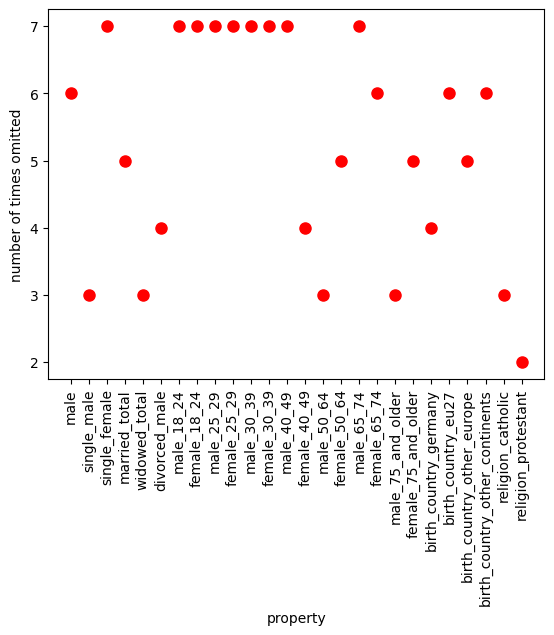

In [102]:
for i in range(len(listg2)):
    count[9,i]=sum(count[0:9,i])
    
plt.plot(listg2,count[9],'o',ms=8,color='red',label='all')
#plt.legend(loc="best")
plt.xlabel("property")
plt.xticks(rotation='vertical')
plt.ylabel("number of times omitted")

['male', 'single_male', 'single_female', 'married_total', 'widowed_total', 'divorced_male', 'male_18_24', 'female_18_24', 'male_25_29', 'female_25_29', 'male_30_39', 'female_30_39', 'male_40_49', 'female_40_49', 'male_50_64', 'female_50_64', 'male_65_74', 'female_65_74', 'male_75_and_older', 'female_75_and_older', 'birth_country_germany', 'birth_country_eu27', 'birth_country_other_europe', 'birth_country_other_continents', 'religion_catholic', 'religion_protestant']
['eligible_voters', 'not_valid_party_votes', 'christian_unions_party_votes', 'social_democrats_party_votes', 'alternative_for_germany_party_votes', 'libertarians_party_votes', 'lefts_party_votes', 'greens_party_votes', 'others_party_votes']
['male', 'single_male', 'single_female', 'married_total', 'widowed_total', 'divorced_male', 'male_18_24', 'female_18_24', 'male_25_29', 'female_25_29', 'male_30_39', 'female_30_39', 'male_40_49', 'female_40_49', 'male_50_64', 'female_50_64', 'male_65_74', 'female_65_74', 'male_75_and_old

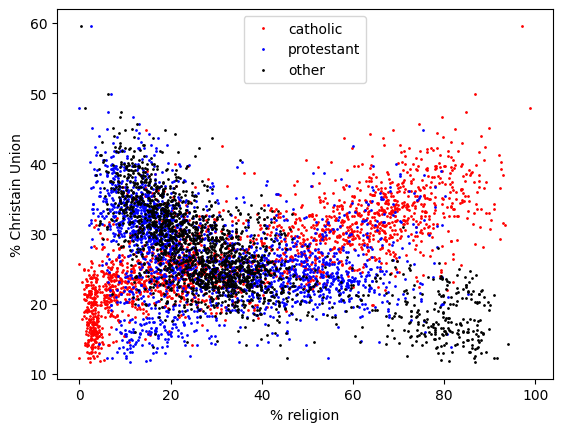

In [103]:
print(listg2)
print(listp2)
plt.plot(feat_train['religion_catholic'],tar_train['christian_unions_party_votes'],'o',ms=1,color='red',label='catholic')
plt.plot(feat_train['religion_protestant'],tar_train['christian_unions_party_votes'],'o',ms=1,color='blue',label='protestant') 
plt.plot(100-feat_train['religion_catholic']-feat_train['religion_protestant'],tar_train['christian_unions_party_votes'],'o',ms=1,color='black',label='other')
plt.legend(loc="best")
plt.xlabel("% religion")
plt.ylabel("% Christain Union")
#plt.xscale("log")
#plt.yscale("log")
print(listg2)
#plot seems right why tehn coeeficient wrong? 

For most properties until now only few rather small countries are missing. This is no different for extreme poverty. We check how that relates with GDP per capita. 

In [104]:
reg = RandomForestRegressor(random_state=1,max_samples=0.5)
statfor=np.zeros((5,len(listp2)))
for i in range(0, len(listp2)):  
    statfor[0,i]=i
    print(listp2[i])

    reg.fit(feat_train,tar_train.iloc[:,i])
    predtr= reg.predict(feat_train)
    predte= reg.predict(feat_test)  
    statfor[1,i]=np.std(tar_train.iloc[:,i])    
    statfor[2,i]=np.std(predtr-tar_train.iloc[:,i])
    statfor[3,i]=np.std(tar_test.iloc[:,i])    
    statfor[4,i]=np.std(predte-tar_test.iloc[:,i])   

eligible_voters
not_valid_party_votes
christian_unions_party_votes
social_democrats_party_votes
alternative_for_germany_party_votes
libertarians_party_votes
lefts_party_votes
greens_party_votes
others_party_votes


[[0.    9.211 3.135 9.04  5.059]
 [1.    0.426 0.203 0.457 0.388]
 [2.    6.524 2.075 6.44  3.219]
 [3.    7.064 2.648 6.751 4.168]
 [4.    5.823 1.786 6.203 2.984]
 [5.    2.807 1.197 2.941 2.169]
 [6.    2.402 0.63  2.314 0.966]
 [7.    5.131 1.557 4.982 2.543]
 [8.    4.29  1.611 4.286 2.621]]


Text(0.5, 0, 'target label number')

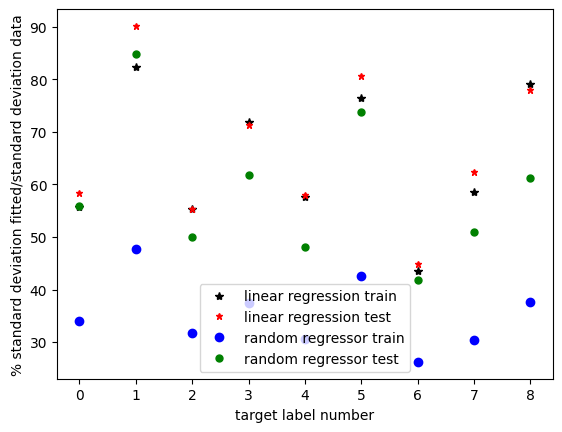

In [105]:
    
print(np.round(statfor.T,3))
plt.plot(statlin[6],100*statlin[2]/statlin[1],'*',ms=6,color='black',label='linear regression train') 
plt.plot(statlin[6],100*statlin[5]/statlin[4],'*',ms=5,color='red',label='linear regression test') 
plt.plot(statfor[0],100*statfor[2]/statfor[1],'o',ms=6,color='blue',label='random regressor train') 
plt.plot(statfor[0],100*statfor[4]/statfor[3],'o',ms=5,color='green',label='random regressor test') 
plt.legend(loc="best")
plt.ylabel("% standard deviation fitted/standard deviation data")
plt.xlabel("target label number")
#plt.yscale("log")
#random rgessor better bit not much still unclear why coefficent are as they are

The coefficients of the fit can be used to obtain tyhe fraction of one category for the data. The calculation assume that categories are independent of each other. That assumption is not correct, since thwere are correlations. 

In [106]:

#normalized means that mean values are already the base
rel=np.zeros((3,9))
for i in range(9):
    rel[0,i]=coefs[26,i]+coefs[24,i]*(100-statg2[0,24])/statg2[1,24]+coefs[25,i]*(0-statg2[0,25])/statg2[1,25]
    rel[1,i]=coefs[26,i]+coefs[24,i]*(0-statg2[0,24])/statg2[1,24]+coefs[25,i]*(100-statg2[0,25])/statg2[1,25]
    rel[2,i]=coefs[26,i]+coefs[24,i]*(0-statg2[0,24])/statg2[1,24]+coefs[25,i]*(0-statg2[0,25])/statg2[1,25]    
print(rel)
print(statg2[0,25])

[[125.4323925    0.6533269   37.04028577  19.79043429   6.84686562
   10.84648522   1.2733106   10.15310741  14.04951109]
 [124.5395991    0.78244126  25.23805012  32.51231736   5.14064094
   12.06938496   0.83405796  16.72002718   7.48552148]
 [141.95190067   1.2592202   17.53334589  22.72544381  22.05030953
   12.28416347   9.11713686   9.42587138   6.86372907]]
30.324389005244896


In [107]:
print(listp2[2:9])
listp3=['christian unions', 'social democrats', 'alternative for germany', 'libertarians', 'lefts', 'greens', 'others']

['christian_unions_party_votes', 'social_democrats_party_votes', 'alternative_for_germany_party_votes', 'libertarians_party_votes', 'lefts_party_votes', 'greens_party_votes', 'others_party_votes']


Text(0.5, 1.0, 'religion')

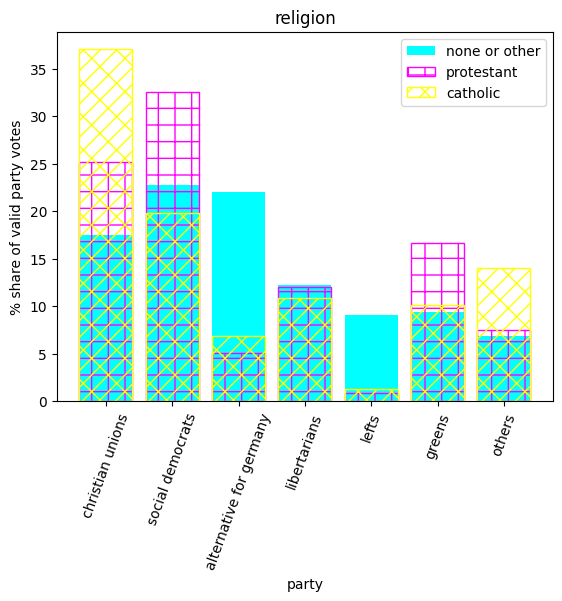

In [108]:
plt.bar(listp3,rel[2,2:9],facecolor='cyan',label='none or other') 
plt.bar(listp3,rel[1,2:9],facecolor='none',edgecolor='magenta',hatch='+',label='protestant') 
plt.bar(listp3,rel[0,2:9],facecolor='none',edgecolor='yellow',hatch='\//',label='catholic') 
plt.legend(loc="best")
plt.xticks(rotation=70)
plt.ylabel("% share of valid party votes")
plt.xlabel("party")
plt.title("religion")

We now analyse the religion voting pattern which seems to be one of the most important indicators. We only use religion categories because when that is correlated with others the correlation needs to be considered while when we do not use the other categories we can just use relegion properties.

For the analysis we just use catholic and protestant, since the rest is fully determined by it. This rest is a combination of several, most important of no religion (most common in East Germany, but partly also adopted to weak beliewers for tax reasons), but also of anthing else besides roman catholic and the main protestant church.  Besides the full Germany analysis we also split the sample into West and East to see how much of the variatian is caused by that. 

In [109]:
#function to fit one category to determine voting pattern per group 
#input full data, features(last is ignored), list of targets
def catfitting(data,listf,listt):
    for i in range(len(listf)-1):
        #exclude rows with bad data
         data=data[(data[listf[i]].isna()==False)]
    #select features         
    feat=data.loc[:,listf[0:len(listf)-1]]
    for i in range(len(listf)-1):
       #get % of population
       feat.iloc[:,i]=feat.iloc[:,i]/data.loc[:,'population']*100
    #normalize now with mean and standard deviation
    stat=np.zeros((2,len(listf)-1))
    for i in range(len(listf)-1):
        m=feat.iloc[:,i].mean()
        s=feat.iloc[:,i].std()
        feat.iloc[:,i]=(feat.iloc[:,i]-m)/s
        stat[0,i]=m
        stat[1,i]=s    
    #get targets (are several which are fit after each other)    
    tar=data.loc[:,listt]
    for i in range(len(listt)):
        tar.iloc[:,i]=tar.iloc[:,i]/data.loc[:,'eligible_voters']*100    
    #coefficients and intercpt of fit    
    coefs=np.zeros((feat.shape[1]+1,len(listt)))
    #statistic like score of fits
    statlin=np.zeros((3,len(listt)))
    for i in range(len(listt)):
        reg = LinearRegression().fit(feat,tar.iloc[:,i]) 
        coefs[0:feat.shape[1],i]=reg.coef_
        coefs[feat.shape[1],i]=reg.intercept_
        predr=reg.predict(feat)    
        statlin[0,i]=tar.iloc[:,i].mean()
        statlin[1,i]=tar.iloc[:,i].std()  
        #fit score
        statlin[2,i]=np.std(tar.iloc[:,i]-predr)
    # get percentage of the groups of the category
    per=np.zeros((feat.shape[1]+1,len(listt)))
    for i in range(len(listt)):
        per[:,i]=coefs[len(listf)-1,i]
        #loop over which property to get %
        for j in range(len(listf)):
            #loop over contributions
            for k in range(len(listf)-1):
                #the contribution of the target for fitted features
                if j==k and j<int(len(listf)-1):
                    per[j,i]+=coefs[k,i]*(100-stat[0,k])/stat[1,k]
                #of the others  for fitted features
                if j!=k and j<int(len(listf)-1):   
                    per[j,i]+=coefs[k,i]*(0-stat[0,k])/stat[1,k]                                                              
                #of not fitted features
                if j>=int(len(listf)-1):   
                    per[j,i]+=coefs[k,i]*(0-stat[0,k])/stat[1,k]                                                                     
    #returns (mean, scatter, fitted scater), coefficients and percentage per property
    return statlin, coefs, per               

In [110]:
#list of parties and co
listp4=['valid_party_votes','not_valid_party_votes', 'christian_unions_party_votes', 'social_democrats_party_votes', 'alternative_for_germany_party_votes', 'libertarians_party_votes', 'lefts_party_votes', 'greens_party_votes', 'others_party_votes']
#select religion
listrel=listg2[24:27]
#add other
listrel.append('religion_other')
print(listrel)
#divide germany in east and west 
sel2e=sel2[sel2['unification']=='East']
sel2w=sel2[sel2['unification']=='West']
#fit full, west east
statrel_f,coefrel_f,perrel_f =catfitting(sel2,listrel,listp4)
statrel_w,coefrel_w,perrel_w =catfitting(sel2w,listrel,listp4)
statrel_e,coefrel_e,perrel_e =catfitting(sel2e,listrel,listp4)

['religion_catholic', 'religion_protestant', 'religion_other']


First we look at turnout. We use here as elsewhere valid votes. While that is not the usual definition it is similar due to the small number of invalid votes. More importantly, it makes the calculations for parties below easier, because we displayed the fraction of valid votes, by using the turnout of valid votes in each category. 

Text(0.5, 0, 'Section')

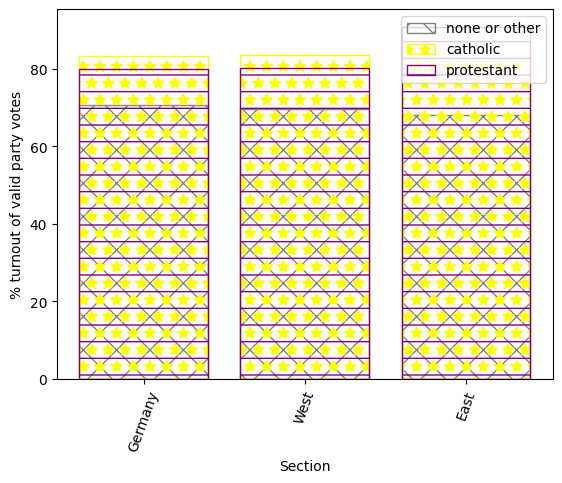

In [111]:

#comboine part for plotting by east west 
perrel=np.zeros((3,9,3))
perrel[:,:,0]=perrel_f
perrel[:,:,1]=perrel_w
perrel[:,:,2]=perrel_e

plt.bar(listf,perrel[2,0,:],facecolor='none',edgecolor='gray',hatch='\\/',label='none or other') 
plt.bar(listf,perrel[0,0,:],facecolor='none',edgecolor='yellow',hatch='*',label='catholic') 
plt.bar(listf,perrel[1,0,:],facecolor='none',edgecolor='purple',hatch='-',label='protestant') 
plt.legend(loc="best")
plt.xticks(rotation=70)
plt.ylabel("% turnout of valid party votes")
plt.xlabel("Section")
#plt.title("East Germany")

Now we look at the party shares of valid votes. 

Text(0.5, 1.0, 'Full Germany')

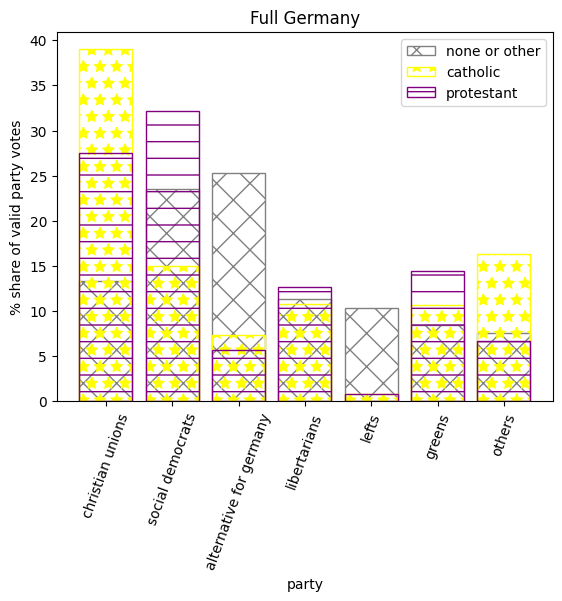

In [112]:
plt.bar(listp3,100*perrel_f[2,2:9]/perrel_f[2,0],facecolor='none',edgecolor='gray',hatch='\\/',label='none or other') 
plt.bar(listp3,100*perrel_f[0,2:9]/perrel_f[0,0],facecolor='none',edgecolor='yellow',hatch='*',label='catholic') 
plt.bar(listp3,100*perrel_f[1,2:9]/perrel_f[1,0],facecolor='none',edgecolor='purple',hatch='-',label='protestant') 
plt.legend(loc="best")
plt.xticks(rotation=70)
plt.ylabel("% share of valid party votes")
plt.xlabel("party")
plt.title("Full Germany")

Text(0.5, 1.0, 'West Germany')

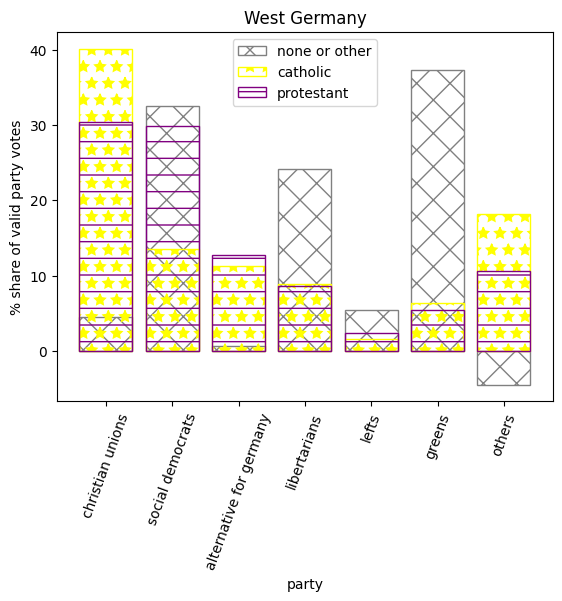

In [113]:
plt.bar(listp3,100*perrel_w[2,2:9]/perrel_w[2,0],facecolor='none',edgecolor='gray',hatch='\\/',label='none or other') 
plt.bar(listp3,100*perrel_w[0,2:9]/perrel_w[0,0],facecolor='none',edgecolor='yellow',hatch='*',label='catholic') 
plt.bar(listp3,100*perrel_w[1,2:9]/perrel_w[1,0],facecolor='none',edgecolor='purple',hatch='-',label='protestant') 
plt.legend(loc="best")
plt.xticks(rotation=70)
plt.ylabel("% share of valid party votes")
plt.xlabel("party")
plt.title("West Germany")

Text(0.5, 1.0, 'East Germany')

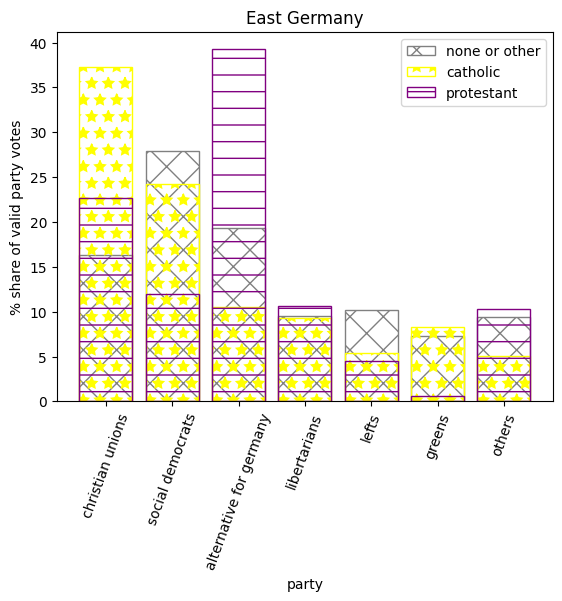

In [114]:
plt.bar(listp3,100*perrel_e[2,2:9]/perrel_e[2,0],facecolor='none',edgecolor='gray',hatch='\\/',label='none or other') 
plt.bar(listp3,100*perrel_e[0,2:9]/perrel_e[0,0],facecolor='none',edgecolor='yellow',hatch='*',label='catholic') 
plt.bar(listp3,100*perrel_e[1,2:9]/perrel_e[1,0],facecolor='none',edgecolor='purple',hatch='-',label='protestant') 
plt.legend(loc="best")
plt.xticks(rotation=70)
plt.ylabel("% share of valid party votes")
plt.xlabel("party")
plt.title("East Germany")

While the results are mostly plausible there seem to be some problems, most obvious for other parties of other reliigion in Western Germany, where there is a negative fraction is obtained, which is not possible. There are several possible reasons like too much outdated census data, differences between the census population and eligible voters and correlation with other properties. 

We plot the data for other parties in Western Germany below. 

Text(0.5, 1.0, 'West Germany')

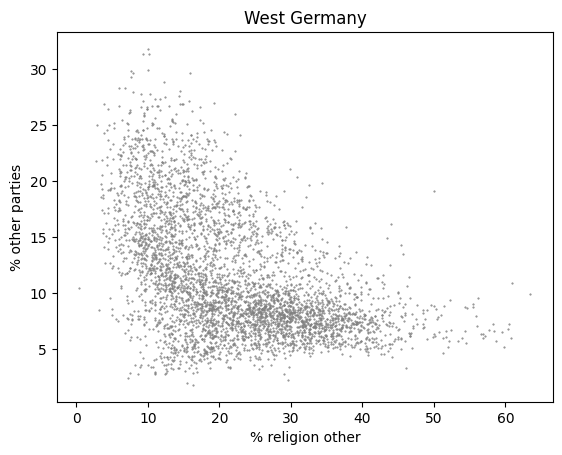

In [115]:

plt.plot(100*(sel2w['population']-sel2w['religion_catholic']-sel2w['religion_protestant'])/sel2w['population'],100*(sel2w['others_party_votes'])/sel2w['valid_party_votes'],'o',ms=0.5,color='gray') 
#plt.legend(loc="best")
plt.xlabel("% religion other")
plt.ylabel("% other parties")
plt.title("West Germany")

It is visisble that the result for 100% requires extrapolation and is such less reliable. Further it is visible the data follows not a simple linear relation. Both of those applies the previously mentioned problems. 

Text(0.5, 0, 'Section')

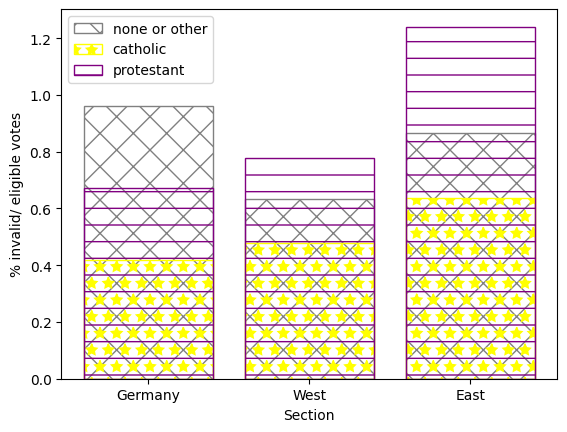

In [116]:
#invalid votes, not important for problem in the way it is set up and numbers are small, thus likely omitted at the end
plt.bar(listf,perrel[2,1,:],facecolor='none',edgecolor='gray',hatch='\\/',label='none or other') 
plt.bar(listf,perrel[0,1,:],facecolor='none',edgecolor='yellow',hatch='*',label='catholic') 
plt.bar(listf,perrel[1,1,:],facecolor='none',edgecolor='purple',hatch='-',label='protestant') 
plt.legend(loc="best")
plt.ylabel("% invalid/ eligible votes")
plt.xlabel("Section")
#plt.title("East Germany")
#alos bad often east and west both on one siide of full

In [117]:
#excluding bad quality at low numbers means some bias towards positive number for small units, some size limit would be good maybe 

Now we look on sex.

In [118]:
listsex=[listg2[0]]
listsex.append('female')
print(listsex)
#fit full, west east
statsex_f,coefsex_f,persex_f =catfitting(sel2,listsex,listp4)
statsex_w,coefsex_w,persex_w =catfitting(sel2w,listsex,listp4)
statsex_e,coefsex_e,persex_e =catfitting(sel2e,listsex,listp4)

['male', 'female']


Text(0.5, 0, 'Section')

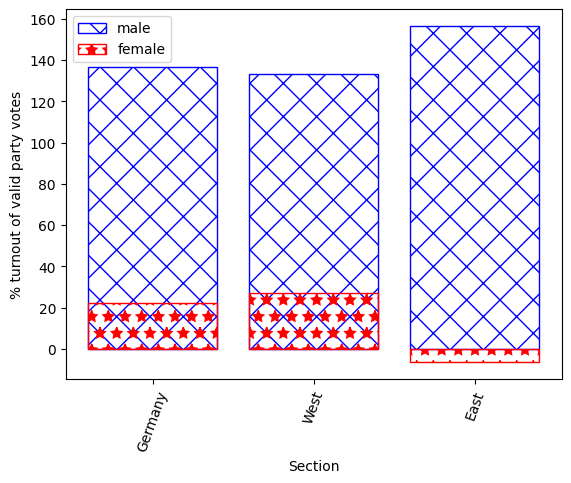

In [119]:
persex=np.zeros((2,9,3))
persex[:,:,0]=persex_f
persex[:,:,1]=persex_w
persex[:,:,2]=persex_e

plt.bar(listf,persex[0,0,:],facecolor='none',edgecolor='blue',hatch='\\/',label='male') 
plt.bar(listf,persex[1,0,:],facecolor='none',edgecolor='red',hatch='*',label='female') 
plt.legend(loc="best")
plt.xticks(rotation=70)
plt.ylabel("% turnout of valid party votes")
plt.xlabel("Section")

Text(0.5, 1.0, 'Full Germany')

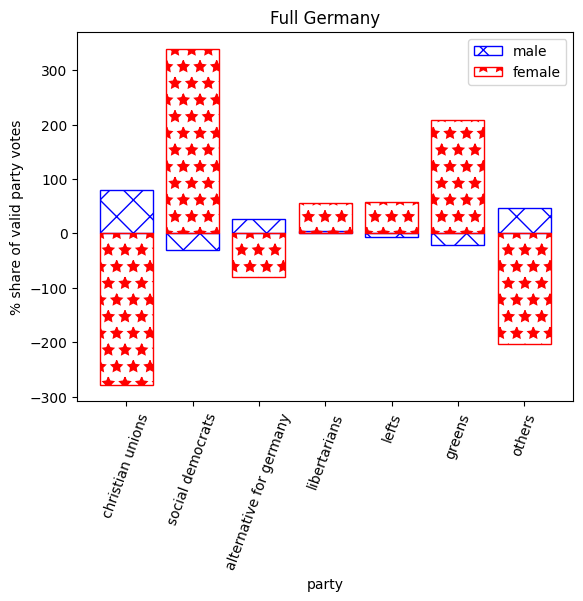

In [120]:
plt.bar(listp3,100*persex_f[0,2:9]/persex_f[0,0],facecolor='none',edgecolor='blue',hatch='\\/',label='male') 
plt.bar(listp3,100*persex_f[1,2:9]/persex_f[1,0],facecolor='none',edgecolor='red',hatch='*',label='female') 
plt.legend(loc="best")
plt.xticks(rotation=70)
plt.ylabel("% share of valid party votes")
plt.xlabel("party")
plt.title("Full Germany")

Text(0.5, 1.0, 'West Germany')

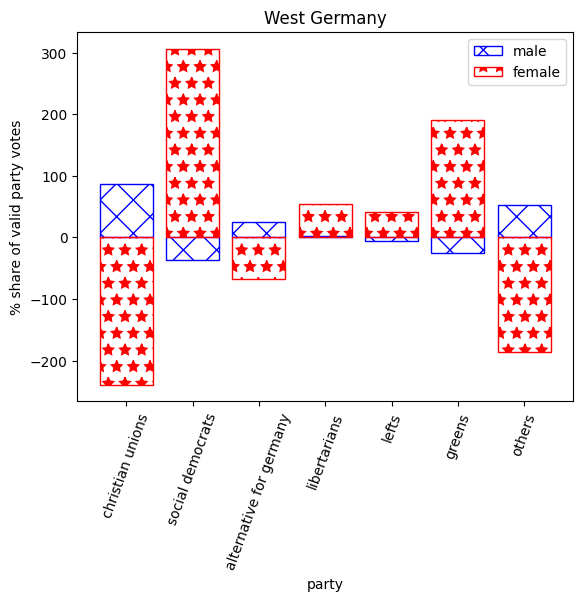

In [121]:
plt.bar(listp3,100*persex_w[0,2:9]/persex_w[0,0],facecolor='none',edgecolor='blue',hatch='\\/',label='male') 
plt.bar(listp3,100*persex_w[1,2:9]/persex_w[1,0],facecolor='none',edgecolor='red',hatch='*',label='female') 
plt.legend(loc="best")
plt.xticks(rotation=70)
plt.ylabel("% share of valid party votes")
plt.xlabel("party")
plt.title("West Germany")

Text(0.5, 1.0, 'East Germany')

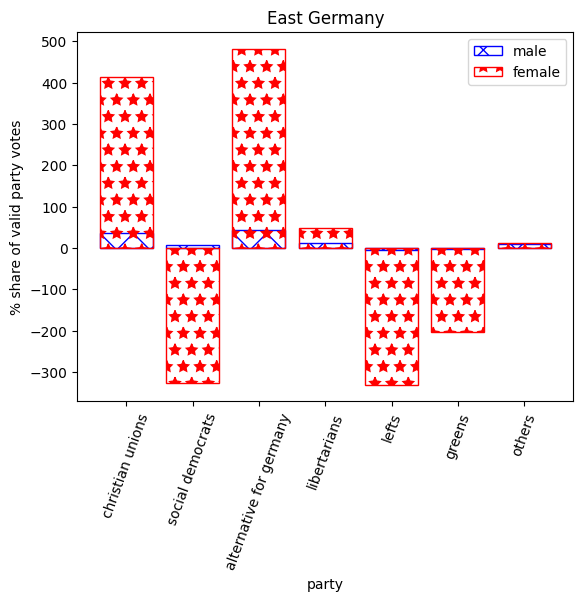

In [122]:
plt.bar(listp3,100*persex_e[0,2:9]/persex_e[0,0],facecolor='none',edgecolor='blue',hatch='\\/',label='male') 
plt.bar(listp3,100*persex_e[1,2:9]/persex_e[1,0],facecolor='none',edgecolor='red',hatch='*',label='female') 
plt.legend(loc="best")
plt.xticks(rotation=70)
plt.ylabel("% share of valid party votes")
plt.xlabel("party")
plt.title("East Germany")

Clearly does not look good for gender. Many have fractions above 100 and below 0. One problem is that it is usually in a small range around 50%. Secondly, the feature seems also minor compared to others. Thus, it is best ignored. 

In [123]:
#(not adults/german exclusion complication)
print(mycat1)
print(cat)

['age' 'birth_country' 'branch' 'citizen' 'education' 'employment'
 'marital_status' 'migration' 'religion' 'school' 'sex' 'work_position'
 'work_type']
['sex', 'sex', 'marital_status', 'marital_status-sex', 'marital_status-sex', 'marital_status', 'marital_status-sex', 'marital_status-sex', 'marital_status', 'marital_status-sex', 'marital_status-sex', 'marital_status', 'marital_status-sex', 'marital_status-sex', 'marital_status', 'marital_status-sex', 'marital_status-sex', 'marital_status', 'marital_status-sex', 'marital_status-sex', 'marital_status', 'marital_status-sex', 'marital_status-sex', 'marital_status', 'marital_status-sex', 'marital_status-sex', 'age', 'age-sex', 'age-sex', 'age', 'age-sex', 'age-sex', 'age', 'age-sex', 'age-sex', 'age', 'age-sex', 'age-sex', 'age', 'age-sex', 'age-sex', 'age', 'age-sex', 'age-sex', 'age', 'age-sex', 'age-sex', 'citizen', 'birth_country', 'birth_country', 'birth_country', 'birth_country', 'birth_country', 'birth_country', 'religion', 'religio

In [126]:
#for now ignore below 18 problem
listmstatus=[]

for i in range(len(listg1b)):
    if cat[i]=="marital_status":
        listmstatus.append(listg1b[i])
print(listmstatus)
#droop very rare ones (is effect other is civil union)
listmstatus=listmstatus[0:5]

#more readable names
listmstatus2=['single', 'married', 'widowed', 'divorced', 'civil union']
print(listmstatus2)

['single_total', 'married_total', 'widowed_total', 'divorced_total', 'civil_union_total', 'civil_union_widowed_total', 'civil_union_divorced_total', 'not_specified_total']
['single', 'married', 'widowed', 'divorced', 'civil union']


In [127]:
#fit full, west east
statmstatus_f,coefmstatus_f,permstatus_f =catfitting(sel2,listmstatus,listp4)
statmstatus_w,coefmstatus,permstatus_w =catfitting(sel2w,listmstatus,listp4)
statmstatus_e,coefmstatus_e,permstatus_e =catfitting(sel2e,listmstatus,listp4)

Text(0.5, 0, 'Section')

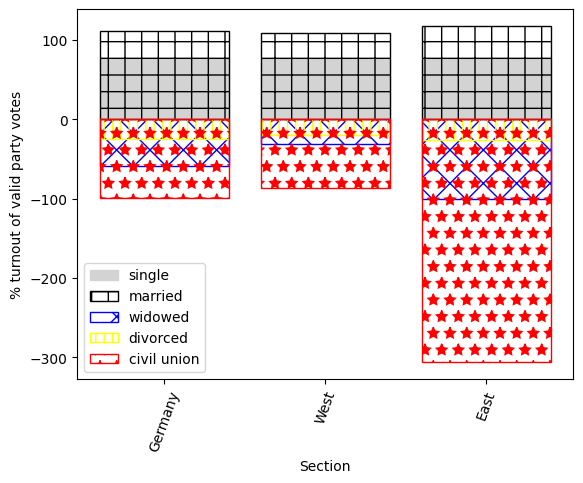

In [128]:
permstatus=np.zeros((5,9,3))
permstatus[:,:,0]=permstatus_f
permstatus[:,:,1]=permstatus_w
permstatus[:,:,2]=permstatus_e

plt.bar(listf,permstatus[0,0,:],facecolor='lightgray',edgecolor='lightgrey',label='single') 
plt.bar(listf,permstatus[1,0,:],facecolor='none',edgecolor='black',hatch='+',label='married') 
plt.bar(listf,permstatus[2,0,:],facecolor='none',edgecolor='blue',hatch='\\/',label='widowed') 
plt.bar(listf,permstatus[3,0,:],facecolor='none',edgecolor='yellow',hatch='||',label='divorced') 
plt.bar(listf,permstatus[4,0,:],facecolor='none',edgecolor='red',hatch='*',label='civil union') 
plt.legend(loc="best")
plt.xticks(rotation=70)
plt.ylabel("% turnout of valid party votes")
plt.xlabel("Section")
#very bad means that fractions is ven worse because that depends on that 

Below nwe slect the number of below 18 in the data. These should be excluded from all the fraction analysis, where thos are nearly all in one category like single. 

In [129]:
#trying both options total-older 
#and younger added together
selage1=sel2.copy()
selage2=sel2.copy()
#older ages
lista1=['total_18_24','total_25_29','total_30_39','total_40_49','total_50_64','total_65_74','total_75_and_older']
#younger ages
lista2=['total_0_2','total_3_5','total_6_14','total_15_17']
for i in range(len(lista1)):

    selage1=selage1[(selage1[lista1[i]].isna()==False)]

for i in range(len(lista2)):
    selage2=selage2[(selage2[lista2[i]].isna()==False)]

print(f"number of communities in full data set {len(sel2)}")     
print(f"number of good communities age selection 1 {len(selage1)}")    
print(f"number of good communities age selection 2 {len(selage2)}")  
selage1['total_17_and_younger']=selage1['population']-(selage1['total_18_24']+selage1['total_25_29']+selage1['total_30_39']+selage1['total_40_49']+selage1['total_50_64']+selage1['total_65_74']+selage1['total_75_and_older'])
#also per sex
selage1['male_17_and_younger']=selage1['male']-(selage1['male_18_24']+selage1['male_25_29']+selage1['male_30_39']+selage1['male_40_49']+selage1['male_50_64']+selage1['male_65_74']+selage1['male_75_and_older'])

selage1['female_17_and_younger']=selage1['female']-(selage1['female_18_24']+selage1['female_25_29']+selage1['female_30_39']+selage1['female_40_49']+selage1['female_50_64']+selage1['female_65_74']+selage1['female_75_and_older'])

number of communities in full data set 5098
number of good communities age selection 1 4612
number of good communities age selection 2 4077


Excluding older is the better options as expected, since there more small subdivisions below 18. 

In [130]:
#probbaly subtract that from all relevant groups +total, that is easier way than create new categories
print(selage1.total_17_and_younger.describe())
print(selage1.population.describe())

count      4612.000000
mean       2491.362533
std       10567.932985
min          16.000000
25%         526.000000
50%        1016.000000
75%        2108.000000
max      494383.000000
Name: total_17_and_younger, dtype: float64
count    4.612000e+03
mean     1.524474e+04
std      6.957008e+04
min      8.900000e+01
25%      3.021750e+03
50%      5.870500e+03
75%      1.222900e+04
max      3.292365e+06
Name: population, dtype: float64


In [133]:
print(mycat1)
#subtract from population, single, not_employable
#for sex use total to derive fractions to reduce problems with less reported 
print(listg1b)
fracm=selage1.male_17_and_younger.sum()/selage1.total_17_and_younger.sum()
fracf=selage1.female_17_and_younger.sum()/selage1.total_17_and_younger.sum()
print(fracm)
print(fracf)
selage1.population=selage1.population-selage1.total_17_and_younger
selage1.male=selage1.male-selage1.total_17_and_younger*fracm
selage1.female=selage1.female-selage1.total_17_and_younger*fracf

selage1.single_total=selage1.single_total-selage1.total_17_and_younger
selage1.single_male=selage1.single_male-selage1.total_17_and_younger*fracm
selage1.single_female=selage1.single_female-selage1.total_17_and_younger*fracf

selage1.not_employable_total=selage1.not_employable_total-selage1.total_17_and_younger
selage1.not_employable_male=selage1.not_employable_male-selage1.total_17_and_younger*fracm
selage1.not_employable_female=selage1.not_employable_female-selage1.total_17_and_younger*fracf

#later to do the same for citizen subtract from non german born, migration data 



['age' 'birth_country' 'branch' 'citizen' 'education' 'employment'
 'marital_status' 'migration' 'religion' 'school' 'sex' 'work_position'
 'work_type']
['male', 'female', 'single_total', 'single_male', 'single_female', 'married_total', 'married_male', 'married_female', 'widowed_total', 'widowed_male', 'widowed_female', 'divorced_total', 'divorced_male', 'divorced_female', 'civil_union_total', 'civil_union_male', 'civil_union_female', 'civil_union_widowed_total', 'civil_union_widowed_male', 'civil_union_widowed_female', 'civil_union_divorced_total', 'civil_union_divorced_male', 'civil_union_divorved_female', 'not_specified_total', 'not_specified_male', 'not_specified_female', 'total_18_24', 'male_18_24', 'female_18_24', 'total_25_29', 'male_25_29', 'female_25_29', 'total_30_39', 'male_30_39', 'female_30_39', 'total_40_49', 'male_40_49', 'female_40_49', 'total_50_64', 'male_50_64', 'female_50_64', 'total_65_74', 'male_65_74', 'female_65_74', 'total_75_and_older', 'male_75_and_older', 'f

Now fitting the data set for marital status with popel younger than 18 subtracted.


In [134]:
#divide germany in east and west 
selage1e=selage1[selage1['unification']=='East']
selage1w=selage1[selage1['unification']=='West']

statmstatus_fb,coefmstatus_fb,permstatus_fb =catfitting(selage1,listmstatus,listp4)
statmstatus_wb,coefmstatus_wb,permstatus_wb =catfitting(selage1w,listmstatus,listp4)
statmstatus_eb,coefmstatus_eb,permstatus_eb =catfitting(selage1e,listmstatus,listp4)

Text(0.5, 0, 'Section')

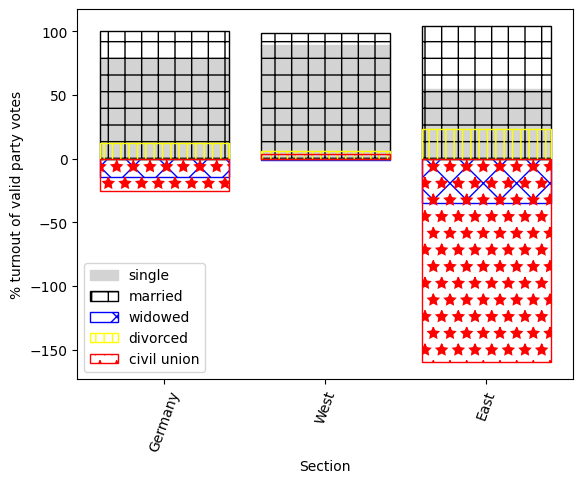

In [135]:
permstatusb=np.zeros((5,9,3))
permstatusb[:,:,0]=permstatus_fb
permstatusb[:,:,1]=permstatus_wb
permstatusb[:,:,2]=permstatus_eb
#nou much better than before

plt.bar(listf,permstatusb[0,0,:],facecolor='lightgray',edgecolor='lightgrey',label='single') 
plt.bar(listf,permstatusb[1,0,:],facecolor='none',edgecolor='black',hatch='+',label='married') 
plt.bar(listf,permstatusb[2,0,:],facecolor='none',edgecolor='blue',hatch='\\/',label='widowed') 
plt.bar(listf,permstatusb[3,0,:],facecolor='none',edgecolor='yellow',hatch='||',label='divorced') 
plt.bar(listf,permstatusb[4,0,:],facecolor='none',edgecolor='red',hatch='*',label='civil union') 
plt.legend(loc="best")
plt.xticks(rotation=70)
plt.ylabel("% turnout of valid party votes")
plt.xlabel("Section")

In [136]:
listmstatusc=['single_total', 'married_total', 'widowed_total', 'divorced_total']
statmstatus_fc,coefmstatus_fc,permstatus_fc =catfitting(selage1,listmstatusc,listp4)
statmstatus_wc,coefmstatus_wc,permstatus_wc =catfitting(selage1w,listmstatusc,listp4)
statmstatus_ec,coefmstatus_ec,permstatus_ec =catfitting(selage1e,listmstatusc,listp4)

Text(0.5, 0, 'Section')

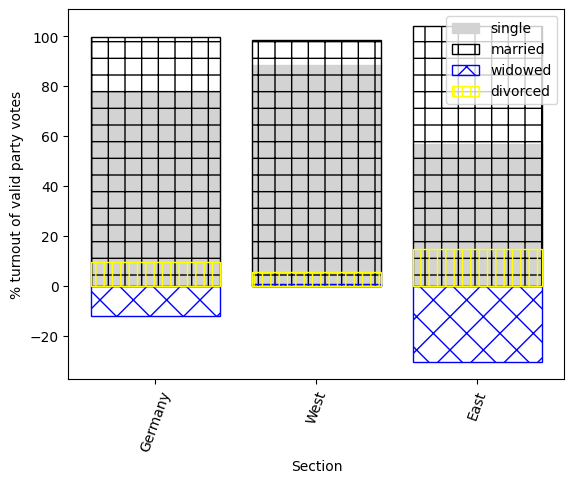

In [137]:
#now w/o civil union
permstatusc=np.zeros((4,9,3))
permstatusc[:,:,0]=permstatus_fc
permstatusc[:,:,1]=permstatus_wc
permstatusc[:,:,2]=permstatus_ec


plt.bar(listf,permstatusc[0,0,:],facecolor='lightgray',edgecolor='lightgrey',label='single') 
plt.bar(listf,permstatusc[1,0,:],facecolor='none',edgecolor='black',hatch='+',label='married') 
plt.bar(listf,permstatusc[2,0,:],facecolor='none',edgecolor='blue',hatch='\\/',label='widowed') 
plt.bar(listf,permstatusc[3,0,:],facecolor='none',edgecolor='yellow',hatch='||',label='divorced') 
plt.legend(loc="best")
plt.xticks(rotation=70)
plt.ylabel("% turnout of valid party votes")
plt.xlabel("Section")
#does not improve means category does not work 

In [140]:
#now unemployment
listu=['employed_total', 'unemployed_total',  'not_employable_total']
print(listu)
stat_un_f,coef_un_f,per_un_f =catfitting(selage1,listu,listp4)
stat_un_w,coef_un_w,per_un_w =catfitting(selage1w,listu,listp4)
stat_un_e,coef_un_e,per_un_e =catfitting(selage1e,listu,listp4)

['employed_total', 'unemployed_total', 'not_employable_total']


Text(0.5, 0, 'Section')

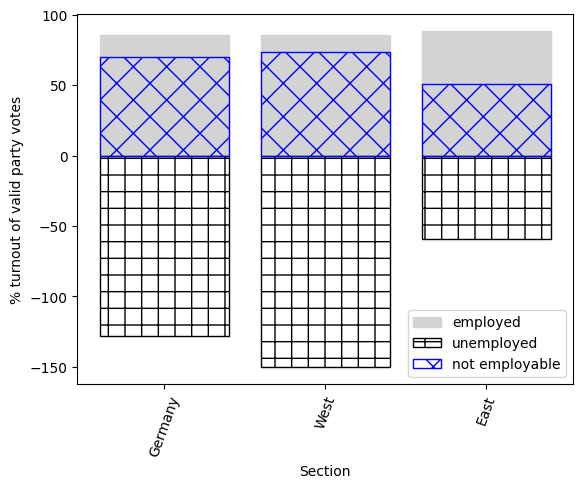

In [141]:
per_un=np.zeros((3,9,3))
per_un[:,:,0]=per_un_f
per_un[:,:,1]=per_un_w
per_un[:,:,2]=per_un_e


plt.bar(listf,per_un[0,0,:],facecolor='lightgray',edgecolor='lightgrey',label='employed') 
plt.bar(listf,per_un[1,0,:],facecolor='none',edgecolor='black',hatch='+',label='unemployed') 
plt.bar(listf,per_un[2,0,:],facecolor='none',edgecolor='blue',hatch='\\/',label='not employable') 
plt.legend(loc="best")
plt.xticks(rotation=70)
plt.ylabel("% turnout of valid party votes")
plt.xlabel("Section")

(58.0, 90.0)

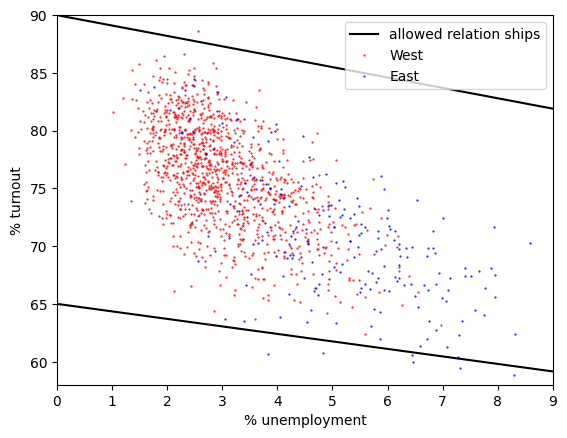

In [143]:
lin=np.zeros((2,2))
lin[0,0]=100
lin[0,1]=0
lin[1,0]=0
lin[1,1]=100
plt.plot(lin[1],lin[0]*0.9,'-',color='black',label='allowed relation ships')
plt.plot(lin[1],lin[0]*0.65,'-',color='black')
plt.plot(100*selage1w['unemployed_total']/selage1w['population'],100*1/(selage1w['eligible_voters'])*selage1w['valid_party_votes'],'o',ms=0.5,color='red',label='West') 
plt.plot(100*selage1e['unemployed_total']/selage1e['population'],100*1/(selage1e['eligible_voters'])*selage1e['valid_party_votes'],'o',ms=0.5,color='blue',label='East') 

plt.legend(loc="best")
plt.xlabel("% unemployment")
plt.ylabel("% turnout")
plt.xlim(0,9)
plt.ylim(58,90)
#plt.title("Germany")

There is a clear relation and as found by the linear regression, the relation ship is strong, so strong that extrapolation leads to negative turnout for 100% unemployed. 

Besides other confusing parameters, another reason could be that also people in contact with unemplyed people change their voting behaviour. 


Text(0.5, 1.0, 'Full Germany')

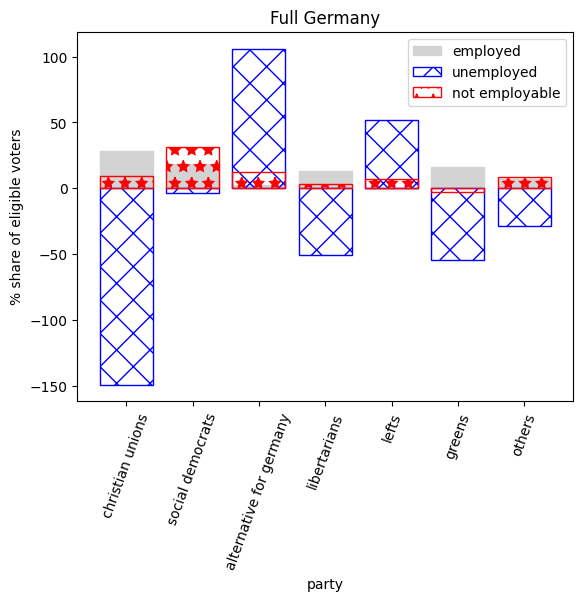

In [144]:
#also as function of eleigble viters not sensible
plt.bar(listp3,per_un_f[0,2:9],facecolor='lightgray',edgecolor='lightgray',label='employed') 
plt.bar(listp3,per_un_f[1,2:9],facecolor='none',edgecolor='blue',hatch='\\/',label='unemployed') 
plt.bar(listp3,per_un_f[2,2:9],facecolor='none',edgecolor='red',hatch='*',label='not employable') 
plt.legend(loc="best")
plt.xticks(rotation=70)
plt.ylabel("% share of eligible voters")
plt.xlabel("party")
plt.title("Full Germany")

In [145]:
print(mycat1)

['age' 'birth_country' 'branch' 'citizen' 'education' 'employment'
 'marital_status' 'migration' 'religion' 'school' 'sex' 'work_position'
 'work_type']


As the next category we look on age. 

In [146]:
lista=['total_18_24','total_25_29','total_30_39','total_40_49','total_50_64','total_65_74','total_75_and_older']
print(lista)
stat_ag_f,coef_ag_f,per_ag_f =catfitting(selage1,lista,listp4)
stat_ag_w,coef_ag_w,per_ag_w =catfitting(selage1w,lista,listp4)
stat_ag_e,coef_ag_e,per_ag_e =catfitting(selage1e,lista,listp4)

['total_18_24', 'total_25_29', 'total_30_39', 'total_40_49', 'total_50_64', 'total_65_74', 'total_75_and_older']


Text(0.5, 0, 'Section')

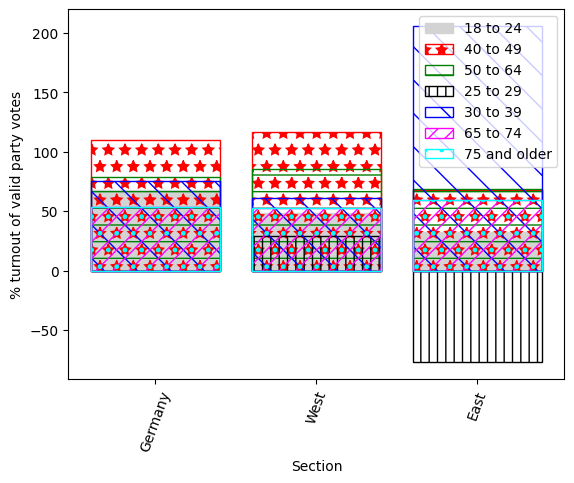

In [147]:
per_ag=np.zeros((7,9,3))
per_ag[:,:,0]=per_ag_f
per_ag[:,:,1]=per_ag_w
per_ag[:,:,2]=per_ag_e


plt.bar(listf,per_ag[0,0,:],facecolor='lightgray',edgecolor='lightgrey',label='18 to 24') 
plt.bar(listf,per_ag[3,0,:],facecolor='none',edgecolor='red',hatch='*',label='40 to 49') 
plt.bar(listf,per_ag[4,0,:],facecolor='none',edgecolor='green',hatch='-',label='50 to 64') 
plt.bar(listf,per_ag[1,0,:],facecolor='none',edgecolor='black',hatch='||',label='25 to 29') 
plt.bar(listf,per_ag[2,0,:],facecolor='none',edgecolor='blue',hatch='\\',label='30 to 39') 
plt.bar(listf,per_ag[5,0,:],facecolor='none',edgecolor='magenta',hatch='//',label='65 to 74') 
plt.bar(listf,per_ag[5,0,:],facecolor='none',edgecolor='cyan',hatch='.',label='75 and older') 
plt.legend(loc="best")
plt.xticks(rotation=70)
plt.ylabel("% turnout of valid party votes")
plt.xlabel("Section")

Text(0.5, 1.0, 'Full Germany')

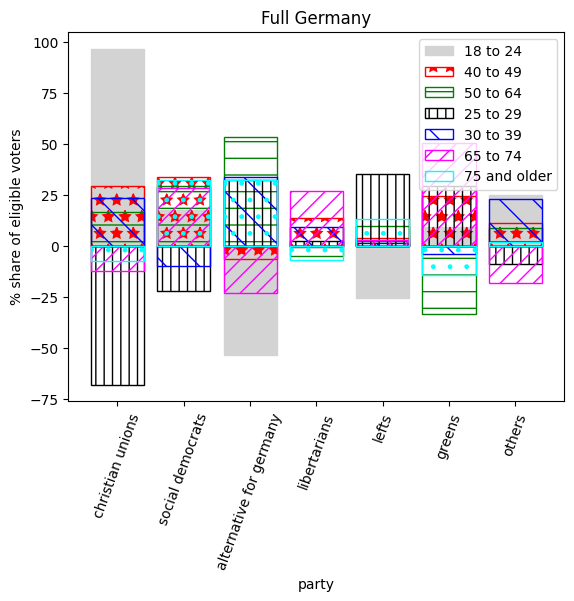

In [148]:
plt.bar(listp3,per_ag_f[0,2:],facecolor='lightgray',edgecolor='lightgrey',label='18 to 24') 
plt.bar(listp3,per_ag_f[3,2:],facecolor='none',edgecolor='red',hatch='*',label='40 to 49') 
plt.bar(listp3,per_ag_f[4,2:],facecolor='none',edgecolor='green',hatch='-',label='50 to 64') 
plt.bar(listp3,per_ag_f[1,2:],facecolor='none',edgecolor='black',hatch='||',label='25 to 29') 
plt.bar(listp3,per_ag_f[2,2:],facecolor='none',edgecolor='blue',hatch='\\',label='30 to 39') 
plt.bar(listp3,per_ag_f[5,2:],facecolor='none',edgecolor='magenta',hatch='//',label='65 to 74') 
plt.bar(listp3,per_ag_f[6,2:],facecolor='none',edgecolor='cyan',hatch='.',label='75 and older') 
plt.legend(loc="best")
plt.xticks(rotation=70)
plt.ylabel("% share of eligible voters")
plt.xlabel("party")
plt.title("Full Germany")

 Ages looks also not good,  besides too big and small fractions, it is also very unplausible that the fraction jumps around a lot between neighboering age classes.  That is not surpirsing, no fraction is ever close enough to 100%.

As the next we look on branches people work. 

First we include all, but we check whether that makes sense.

In [149]:
print(mycat1)
listbr1=['agriculture', 'mining_and_industry', 'distribution', 'building', 'sale_car_repair_dining', 'traffic_communication', 'finance_insurance', 'real_estate_science', 'public_administration', 'public_private_services']
tot=0
for i in range(len(listbr1)):
    ser=selage1[(selage1[listbr1[i]].isna()==False)]
    ser=ser[listbr1[i]]/ser['population']
    print(f"{listbr1[i]} has max of {round(100*ser.max(),2)}%, mean of {round(100*ser.mean(),2)} %")
    print(f"available for {len(ser)} communities")
    tot+=ser.mean()
print(f"sum of mean of branches is {round(100*tot)} %")  
#used branches
print("now excluding some")
listbr2=[ 'mining_and_industry', 'sale_car_repair_dining', 'traffic_communication', 'real_estate_science', 'public_administration', 'public_private_services']
tot2=0
for i in range(len(listbr2)):
    ser=selage1[  (selage1[listbr2[i]].isna()==False)]
    ser=ser[listbr2[i]]/ser['population']
    print(f"{listbr2[i]} has max of {round(100*ser.max(),2)}%, mean of {round(100*ser.mean(),2)} %")
    print(f"available for {len(ser)} communities")
    tot2+=ser.mean()
    
    
print(f"sum of mean of used branches is {round(100*tot2)} %")  

['age' 'birth_country' 'branch' 'citizen' 'education' 'employment'
 'marital_status' 'migration' 'religion' 'school' 'sex' 'work_position'
 'work_type']
agriculture has max of 13.16%, mean of 2.39 %
available for 415 communities
mining_and_industry has max of 38.99%, mean of 16.65 %
available for 1457 communities
distribution has max of 4.15%, mean of 1.09 %
available for 734 communities
building has max of 11.98%, mean of 4.41 %
available for 1208 communities
sale_car_repair_dining has max of 30.9%, mean of 13.28 %
available for 1436 communities
traffic_communication has max of 19.98%, mean of 6.05 %
available for 1229 communities
finance_insurance has max of 10.28%, mean of 2.63 %
available for 974 communities
real_estate_science has max of 18.91%, mean of 9.15 %
available for 1349 communities
public_administration has max of 18.01%, mean of 5.86 %
available for 1254 communities
public_private_services has max of 36.5%, mean of 17.5 %
available for 1459 communities
sum of mean of bra

We decide to included bracnhes which have a maximum larger than 10% and have information for at least 1000 communities. 

Sunce the sum of those branches is only 9 is of the previous one, the rest is donomnaited by the n not working population.

In [150]:
listbr=[ 'mining_and_industry', 'sale_car_repair_dining', 'traffic_communication', 'real_estate_science', 'public_administration', 'public_private_services','not_working']
print(listbr)
stat_br_f,coef_br_f,per_br_f =catfitting(selage1,listbr,listp4)
stat_br_w,coef_br_w,per_br_w =catfitting(selage1w,listbr,listp4)
stat_br_e,coef_br_e,per_br_e =catfitting(selage1e,listbr,listp4)

['mining_and_industry', 'sale_car_repair_dining', 'traffic_communication', 'real_estate_science', 'public_administration', 'public_private_services', 'not_working']


(0.0, 250.0)

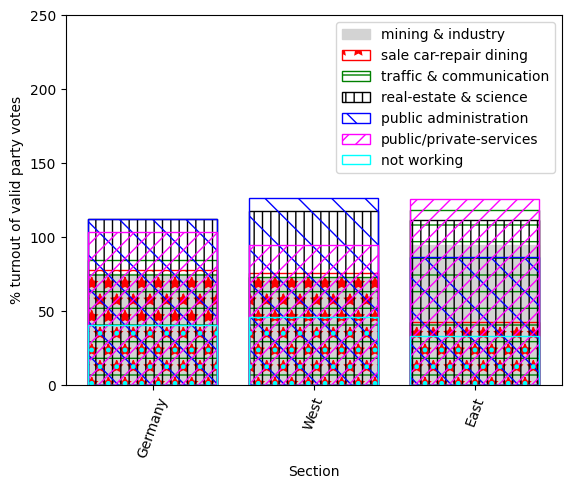

In [151]:
per_br=np.zeros((7,9,3))
per_br[:,:,0]=per_br_f
per_br[:,:,1]=per_br_w
per_br[:,:,2]=per_br_e


plt.bar(listf,per_br[0,0,:],facecolor='lightgray',edgecolor='lightgrey',label='mining & industry') 
plt.bar(listf,per_br[1,0,:],facecolor='none',edgecolor='red',hatch='*',label='sale car-repair dining') 
plt.bar(listf,per_br[2,0,:],facecolor='none',edgecolor='green',hatch='-',label='traffic & communication') 
plt.bar(listf,per_br[3,0,:],facecolor='none',edgecolor='black',hatch='||',label='real-estate & science') 
plt.bar(listf,per_br[4,0,:],facecolor='none',edgecolor='blue',hatch='\\',label='public administration') 
plt.bar(listf,per_br[5,0,:],facecolor='none',edgecolor='magenta',hatch='//',label='public/private-services') 
plt.bar(listf,per_br[6,0,:],facecolor='none',edgecolor='cyan',hatch='.',label='not working') 
plt.legend(loc="best")
plt.xticks(rotation=70)
plt.ylabel("% turnout of valid party votes")
plt.xlabel("Section")
plt.ylim(0,250)

Looks better than many other categoreis at least the number are between 0 and 150%. 

Text(0.5, 1.0, 'Full Germany')

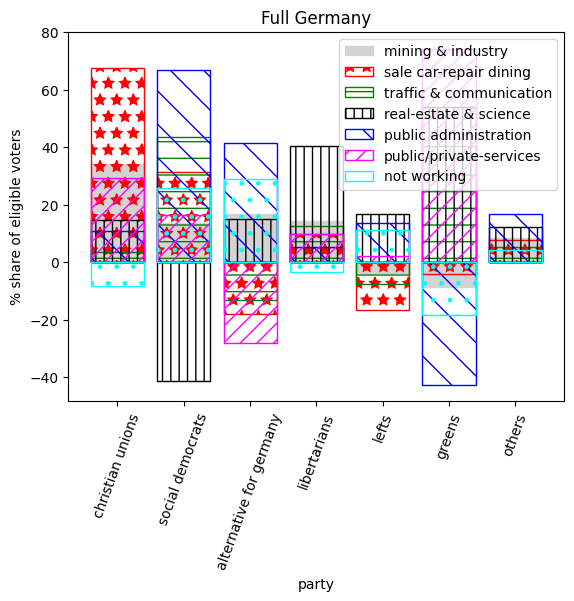

In [152]:
plt.bar(listp3,per_br_f[0,2:],facecolor='lightgray',edgecolor='lightgrey',label='mining & industry') 
plt.bar(listp3,per_br_f[1,2:],facecolor='none',edgecolor='red',hatch='*',label='sale car-repair dining') 
plt.bar(listp3,per_br_f[2,2:],facecolor='none',edgecolor='green',hatch='-',label='traffic & communication') 
plt.bar(listp3,per_br_f[3,2:],facecolor='none',edgecolor='black',hatch='||',label='real-estate & science') 
plt.bar(listp3,per_br_f[4,2:],facecolor='none',edgecolor='blue',hatch='\\',label='public administration') 
plt.bar(listp3,per_br_f[5,2:],facecolor='none',edgecolor='magenta',hatch='//',label='public/private-services') 
plt.bar(listp3,per_br_f[6,2:],facecolor='none',edgecolor='cyan',hatch='.',label='not working') 
plt.legend(loc="best")
plt.xticks(rotation=70)
plt.ylabel("% share of eligible voters")
plt.xlabel("party")
plt.title("Full Germany")

However, does not look plausible. 

Text(0.5, 1.0, 'West Germany')

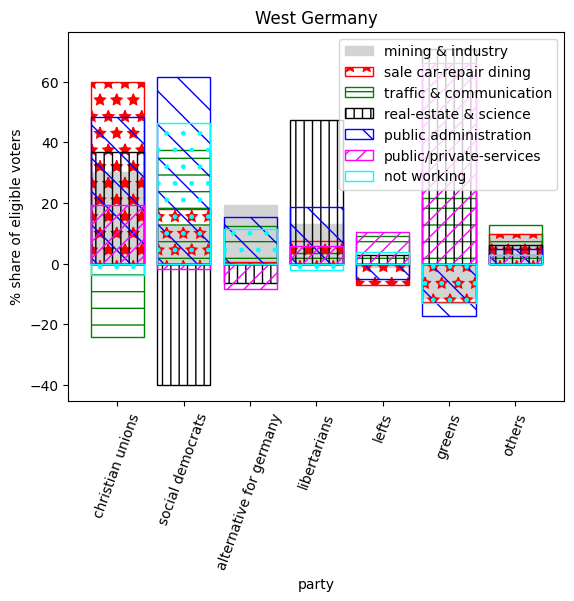

In [153]:
plt.bar(listp3,per_br_w[0,2:],facecolor='lightgray',edgecolor='lightgrey',label='mining & industry') 
plt.bar(listp3,per_br_w[1,2:],facecolor='none',edgecolor='red',hatch='*',label='sale car-repair dining') 
plt.bar(listp3,per_br_w[2,2:],facecolor='none',edgecolor='green',hatch='-',label='traffic & communication') 
plt.bar(listp3,per_br_w[3,2:],facecolor='none',edgecolor='black',hatch='||',label='real-estate & science') 
plt.bar(listp3,per_br_w[4,2:],facecolor='none',edgecolor='blue',hatch='\\',label='public administration') 
plt.bar(listp3,per_br_w[5,2:],facecolor='none',edgecolor='magenta',hatch='//',label='public/private-services') 
plt.bar(listp3,per_br_w[6,2:],facecolor='none',edgecolor='cyan',hatch='.',label='not working') 
plt.legend(loc="best")
plt.xticks(rotation=70)
plt.ylabel("% share of eligible voters")
plt.xlabel("party")
plt.title("West Germany")

Now looking on professional education. 

In [154]:
print(mycat1)
print(len(listg1b))
print(listg1b[115:122])
listed=listg1b[115:122]
tot=0
for i in range(len(listed)):
    ser=selage1[(selage1[listed[i]].isna()==False)]
    ser=ser[listed[i]]/ser['population']
    print(f"{listed[i]} has max of {round(100*ser.max(),2)}%, mean of {round(100*ser.mean(),2)} %")
    print(f"available for {len(ser)} communities")
    tot+=ser.mean()
print(f"sum of mean of branches is {round(100*tot)} %") 




['age' 'birth_country' 'branch' 'citizen' 'education' 'employment'
 'marital_status' 'migration' 'religion' 'school' 'sex' 'work_position'
 'work_type']
122
['no_profession_education', 'apprenticeship', 'professional_school', 'professional_academy', 'community_college', 'university', 'PhD_and_MD']
no_profession_education has max of 63.93%, mean of 34.25 %
available for 1472 communities
apprenticeship has max of 85.72%, mean of 61.79 %
available for 1472 communities
professional_school has max of 24.05%, mean of 14.09 %
available for 1472 communities
professional_academy has max of 7.14%, mean of 2.49 %
available for 779 communities
community_college has max of 17.37%, mean of 7.27 %
available for 1472 communities
university has max of 39.64%, mean of 8.56 %
available for 1471 communities
PhD_and_MD has max of 12.19%, mean of 2.92 %
available for 363 communities
sum of mean of branches is 131 %


The total is slightly obver 100, because some are already finished before 18. Still 5 is small enough that it does not matter much. 

In [157]:
listed2=['no_profession_education', 'apprenticeship', 'professional_school', 'community_college', 'university']

In [158]:
tot=0
for i in range(len(listed2)):
    ser=selage1[(selage1[listed2[i]].isna()==False)]
    ser=ser[listed2[i]]/ser['population']
    print(f"{listed2[i]} has max of {round(100*ser.max(),2)}%, mean of {round(100*ser.mean(),2)} %")
    print(f"available for {len(ser)} communities")
    tot+=ser.mean()
print(f"sum of mean of branches is {round(100*tot)} %") 
#or summarize some to just 3 main? 

no_profession_education has max of 63.93%, mean of 34.25 %
available for 1472 communities
apprenticeship has max of 85.72%, mean of 61.79 %
available for 1472 communities
professional_school has max of 24.05%, mean of 14.09 %
available for 1472 communities
community_college has max of 17.37%, mean of 7.27 %
available for 1472 communities
university has max of 39.64%, mean of 8.56 %
available for 1471 communities
sum of mean of branches is 126 %


In [159]:
listed3=['no_profession_education', 'apprenticeship', 'professional_school', 'community_college', 'university','other']
print(len(listed3))

6


In [160]:
stat_ed_f,coef_ed_f,per_ed_f =catfitting(selage1,listed3,listp4)
stat_ed_w,coef_ed_w,per_ed_w =catfitting(selage1w,listed3,listp4)
stat_ed_e,coef_ed_e,per_ed_e =catfitting(selage1e,listed3,listp4)

(0.0, 250.0)

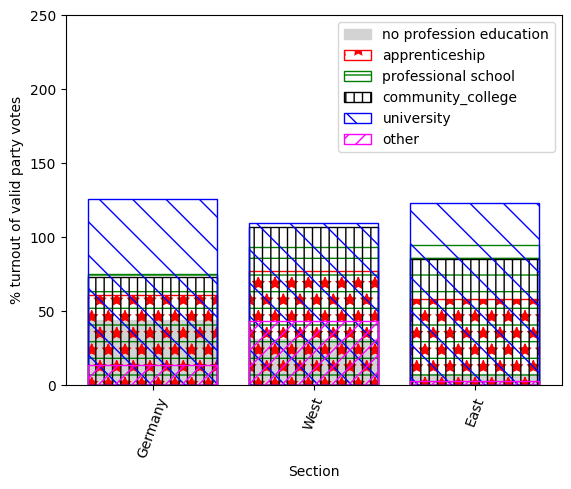

In [161]:
per_ed=np.zeros((6,9,3))
per_ed[:,:,0]=per_ed_f
per_ed[:,:,1]=per_ed_w
per_ed[:,:,2]=per_ed_e


plt.bar(listf,per_ed[0,0,:],facecolor='lightgray',edgecolor='lightgrey',label='no profession education') 
plt.bar(listf,per_ed[1,0,:],facecolor='none',edgecolor='red',hatch='*',label='apprenticeship') 
plt.bar(listf,per_ed[2,0,:],facecolor='none',edgecolor='green',hatch='-',label='professional school') 
plt.bar(listf,per_ed[3,0,:],facecolor='none',edgecolor='black',hatch='||',label='community_college') 
plt.bar(listf,per_ed[4,0,:],facecolor='none',edgecolor='blue',hatch='\\',label='university') 
plt.bar(listf,per_ed[5,0,:],facecolor='none',edgecolor='magenta',hatch='//',label='other')  
plt.legend(loc="best")
plt.xticks(rotation=70)
plt.ylabel("% turnout of valid party votes")
plt.xlabel("Section")
plt.ylim(0,250)

Text(0.5, 0, 'Section')

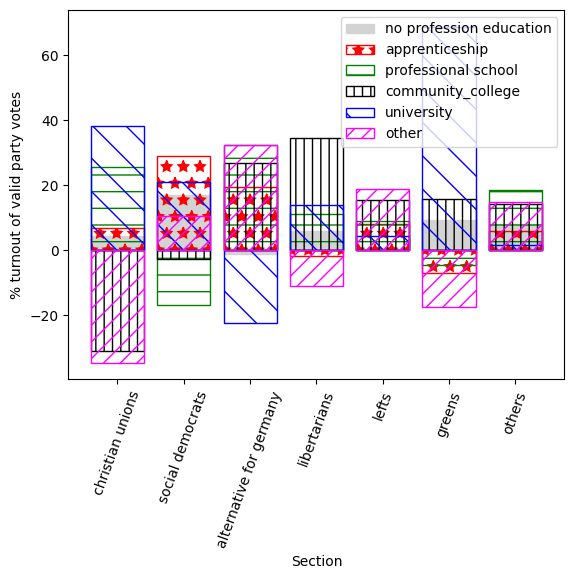

In [162]:
plt.bar(listp3,per_ed_f[0,2:],facecolor='lightgray',edgecolor='lightgrey',label='no profession education') 
plt.bar(listp3,per_ed_f[1,2:],facecolor='none',edgecolor='red',hatch='*',label='apprenticeship') 
plt.bar(listp3,per_ed_f[2,2:],facecolor='none',edgecolor='green',hatch='-',label='professional school') 
plt.bar(listp3,per_ed_f[3,2:],facecolor='none',edgecolor='black',hatch='||',label='community_college') 
plt.bar(listp3,per_ed_f[4,2:],facecolor='none',edgecolor='blue',hatch='\\',label='university') 
plt.bar(listp3,per_ed_f[5,2:],facecolor='none',edgecolor='magenta',hatch='//',label='other')  
plt.legend(loc="best")
plt.xticks(rotation=70)
plt.ylabel("% turnout of valid party votes")
plt.xlabel("Section")
#plt.ylim(0,250)

Better, but not plasuible, try with only three category, no professional eduction, profesional, college. 